# **Project 1: Induction Heads**
---

In this notebook I walk through replication of Antropic's work on induction heads and in-context learning in transformer models.

## **Overview**

In this project I'm exploring **induction heads** - a mechanistic component that allows transformers to perform in-context learning. This notebook works through how simple two-layer circuits can implement pattern matching and completion, in addition to exploring how their removal affects the performance of in-context learning.

## **References**

Check out the links to Anthropic's original publications on their investigation of induction heads:

**Original Papers:**

- [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html) (Anthropic, 2021)

- [In-context Learning and Induction Heads](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html) (Anthropic, 2022)

See also Chapter 1.2 of ARENA's coursework which goes over these topics and and which was used as inspiration for this notebook:

**ARENA Coursework:**

- [ARENA Chapter 1.2: Intro to Mech Interp](https://arena-chapter1-transformer-interp.streamlit.app/[1.2]_Intro_to_Mech_Interp) (ARENA)

- [ARENA Github](https://github.com/callummcdougall/ARENA_3.0) (ARENA)



---





## **What are Induction Heads?**

Induction heads are attention heads that:

1. Look for repeating patterns like `[A][B] ... [A]` in the input
2. When they see `[A]` again (later in the context), they then attend back to the token that came after the previous `[A]`, which in this case is the token `[B]`
3. This then allows the model to predict `[B]` as the token that should come next

This ability for the model to learn from examples in the prompt without needing to update its weights is one of the fundamental building blocks for in-context learning

## **Induction Head Circuit Structure Overview**

Two-layers (at a minimum) are required for the model to be able to perform induction behaviour. These two layers occur sequentially and contain the following types of attention heads:

### **Layer 0: Previous Token Heads**

 - Attention heads that attend from position `i` to position `i-1`
 - Previous Token Heads essentially write "this token was preceded by X" into the residual stream

### **Layer 1: Induction Heads**

  - Attention heads that attend to positions where the same token appeared before (in the prompt/context)
  - They use the information from the previous token heads to predict the next token
  - Induction heads then complete the pattern matching behaviour

Now, let's get started with actually investigating induction heads in a model...

---



## **Code Walkthrough**

In the following sections we're going to walkthrough the steps of how we can explore the induction heads in a simple small model. The code block for each step should be run sequentially in the order they appear below in the notebook.



## **Step 0: Setup the Environment:**

I used Google Colab for this Notebook as it's straightforward to get GPU resources, so recommend this approach.

In [1]:
pip install transformer-lens torch einops git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-phop5m46
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-phop5m46
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## **Step 1: Load a Model**

Exploring GPT-2 small as the model as this is what was used originally in the ARENA coursework material

In [2]:
from IPython.display import clear_output, display, HTML
import numpy as np
import torch
from torch import Tensor
import torch.nn.functional as F
from transformer_lens import HookedTransformer, utils
import einops
import circuitsvis as cv
from jaxtyping import Float, Int

torch.set_grad_enabled(False)

# Load a small 2-layer model
model = HookedTransformer.from_pretrained(
    "gpt2-small",       # Has 12 layers, but only need to look at the first 2
    device="cuda" if torch.cuda.is_available() else "cpu"
)
clear_output()
print(f"Model has {model.cfg.n_layers} layers")
print(f"Each layer has {model.cfg.n_heads} heads")


Model has 12 layers
Each layer has 12 heads


# **Step 2: Create Induction-Friendly Sequences**

- Need to generate datasets that can to highlight induction behaviour
- Can use repeated sequences (of sentences or random tokens) to test pattern matching

In [4]:
# Create datasets with sequences of repeated tokens
print(f"\nDatasets:\n")

# 1) Sentence Example Dataset: quotes from "Ghost in the Shell" :)
sentence_example_dataset = ["I lack the most basic processes inherent in all living organisms: reproducing and dying", "My ghost survived to remind the next of us... that humanity is our virtue", "man is an individual only because of his intangible memory"]
sentence_example_prompts = []
for example in sentence_example_dataset:
  sentence_example_prompts.append(" ".join([example, example, example, example, example]))
sentence_dataset_tokens = model.to_tokens(sentence_example_prompts)
print(f"{"-"*60}")
print(f"Sentence Dataset:")
print(f"\tSentence Dataset Token shape: {sentence_dataset_tokens.shape}")  # [batch, seq_len]
print(f"\tExample Prompt: {sentence_example_prompts[0]}\n")

# 2) Alphabet Example Dataset:
alphabet_example_dataset = "a b c d e f g h i j k l m n o p q r s t u v w x y z"
alphabet_example_prompts = " ".join([alphabet_example_dataset, alphabet_example_dataset, alphabet_example_dataset])
alphabet_dataset_tokens = model.to_tokens(alphabet_example_prompts)
print(f"{"-"*60}")
print(f"Alphabet Dataset:")
print(f"\tAlphabet Dataset Token shape: {alphabet_dataset_tokens.shape}")  # [batch, seq_len]
print(f"\tExample Prompt: {alphabet_example_prompts}\n")

# 3) Random Sequences Example Dataset: (The first 100 tokens in GPT-2 are special tokens so should be ignored)
sequence_length = 26
random_sequence_example_dataset = torch.randint(1000, 2000, (1, sequence_length))
random_sequence_example_tokens = torch.cat([random_sequence_example_dataset, random_sequence_example_dataset, random_sequence_example_dataset], dim=1)
random_sequence_dataset_tokens = random_sequence_example_tokens.to(model.cfg.device)
print(f"{"-"*60}")
print(f"Random Sequence Dataset:")
print(f"Random Sequence Dataset Token shape: {random_sequence_dataset_tokens.shape}")  # [batch, seq_len]
print(f"\tExample Token Sequence: {random_sequence_dataset_tokens}\n")

# Store the token datasets in a dictionary for easy switching during testing
token_datasets = {
    "sentence": sentence_dataset_tokens,
    "alphabet": alphabet_dataset_tokens,
    "random": random_sequence_dataset_tokens,
}



Datasets:

------------------------------------------------------------
Sentence Dataset:
	Sentence Dataset Token shape: torch.Size([3, 81])
	Example Prompt: I lack the most basic processes inherent in all living organisms: reproducing and dying I lack the most basic processes inherent in all living organisms: reproducing and dying I lack the most basic processes inherent in all living organisms: reproducing and dying I lack the most basic processes inherent in all living organisms: reproducing and dying I lack the most basic processes inherent in all living organisms: reproducing and dying

------------------------------------------------------------
Alphabet Dataset:
	Alphabet Dataset Token shape: torch.Size([1, 79])
	Example Prompt: a b c d e f g h i j k l m n o p q r s t u v w x y z a b c d e f g h i j k l m n o p q r s t u v w x y z a b c d e f g h i j k l m n o p q r s t u v w x y z

------------------------------------------------------------
Random Sequence Dataset:
Random Seq

# **Step 3: Run Model and Cache Activations**

In [5]:
# Run the Model and Cache Activations
names_filter = lambda name: any(name.endswith(f"hook_{s}") for s in ["pattern", "q", "k", "v"])
logits, cache = model.run_with_cache(token_datasets["sentence"], names_filter=names_filter, remove_batch_dim=True)

# Get the attention from the cached model activations
#attn: Float[Tensor, "layers heads seq_Q seq_K"] = torch.stack([cache["pattern", i] for i in range(model.cfg.n_layers)])

# Cache contains all attention patterns
# Access with: cache["pattern", layer, "attn"]
#print(f"Available cache keys: {list(cache.keys())}")

# **Step 4: Detect Previous Token Heads (Layer 0)**

- Make a function to detect previous token heads in the model

In [6]:
def detect_prev_token_heads_in_model(model, dataset, previous_token_head_threshold=0.4, names_filter_keys=["pattern", "q", "k", "v"]):
  """
  Detect heads in an input model that attend to the previous token.

  Returns scores for each head in the model indicating how much it attends to
  position i-1 when at position i
  """

  # Only get the keys of interest (don't need the full cache)
  names_filter = lambda name: any(name.endswith(f"hook_{s}") for s in names_filter_keys)

  # Run model and cache the activations
  logits, cache = model.run_with_cache(dataset, names_filter=names_filter)

  # Loop over all the layers in the model
  previous_token_heads_per_layer = {}
  previous_token_head_scores = {}

  # Loop over the layers
  for layer_idx in range(0, model.cfg.n_layers):

    # Add new entry in the results dictionaries for the current layer
    previous_token_head_scores[layer_idx] = {}
    prev_token_scores = detect_prev_token_heads_updated(cache, layer=layer_idx)

    # Get only the heads above the threshold
    prev_token_heads = (prev_token_scores > previous_token_head_threshold).nonzero().squeeze()
    previous_token_heads_per_layer[layer_idx] = prev_token_heads.tolist()

  return previous_token_heads_per_layer, previous_token_head_scores, cache

def detect_prev_token_heads(cache, layer=0):
  """
  Detect heads that attend to the previous token.

  Returns scores for each head indicating how much it attends to
  position i-1 when at position i
  """

  # Get attention patterns for this layer
  # Shape: [batch, head, query_pos, key_pos]
  attn_patterns = cache["pattern", layer]

  batch, n_heads, seq_len, _ = attn_patterns.shape

  # Old implementation:
  # Create a diagonal mask shifted by 1 (attending to previous token)
  # We want attend from position i to position i-1
  prev_token_mask = torch.zeros(seq_len, seq_len)
  for i in range(1, seq_len):
    prev_token_mask[i, i-1] = 1.0

  prev_token_mask = prev_token_mask.to(attn_patterns.device)

  # Score: how much does each head attend to the previous token?
  # Average over batch and positions
  scores = einops.einsum(
      attn_patterns,
      prev_token_mask,
      "batch head query key, query key -> head"
  ) / (seq_len-1)        # Normalize by number of valid positions

  return scores

def detect_prev_token_heads_updated(cache, layer=0):
  """
  Detect heads that attend to the previous token.

  Returns scores for each head indicating how much it attends to
  position i-1 when at position i
  """

  # Get attention patterns for this layer
  # Shape: [batch, head, query_pos, key_pos]
  attn_patterns = cache["pattern", layer]
  batch, n_heads, seq_len, _ = attn_patterns.shape
  scores = torch.zeros(n_heads, device=attn_patterns.device)

  if seq_len <= 1:
      return scores # Return all zeros if sequence is too short to have a previous token

  for head in range(n_heads):
    # Get the attention patterns for this head across all batches
    # Shape: [batch, query_pos, key_pos]
    head_attn = attn_patterns[:, head, :, :]

    # Extract the diagonal corresponding to attending to the previous token (offset -1)
    # This will be of shape [batch, seq_len - 1]
    prev_token_attention = head_attn.diagonal(offset=-1, dim1=-2, dim2=-1)

    # Average over the sequence positions (dim=-1) and then average over batches
    scores[head] = prev_token_attention.mean(dim=-1).mean()

  return scores

# Run function to find the previous token heads in the model
previous_token_heads_per_layer, previous_token_head_scores, cache = detect_prev_token_heads_in_model(model=model, dataset=token_datasets["sentence"][1], previous_token_head_threshold=0.4)

# Loop over layers and print the previous token heads in each layer
print(f"Previous Token Heads Detected:")
for layer_idx in range(0, model.cfg.n_layers):
  print(f"\tLayer {layer_idx}: {previous_token_heads_per_layer[layer_idx]}")

# Now, visualise the heads
tokens = model.to_str_tokens(token_datasets["sentence"][1])

_attention = cache["pattern", 3] # [heads seqQ seqK]
_tokens = tokens # [seq]

cv.attention.from_values(
    attention = _attention,
    tokens = _tokens,
    attention_head_names = [f"3.{H}" for H in range(12)],
)

Previous Token Heads Detected:
	Layer 0: []
	Layer 1: []
	Layer 2: 2
	Layer 3: [2, 7]
	Layer 4: 11
	Layer 5: []
	Layer 6: 8
	Layer 7: []
	Layer 8: []
	Layer 9: []
	Layer 10: []
	Layer 11: []
You're using 4D attention with a batch dimension of size 1. We have removed the batch dimension for you.


# **Step 5: Detect Induction Heads (Layer 1)**

- Make a function to detect induction heads in the model
- Does the induction score improve during increasing repetition in the context?

In [50]:
def get_log_probs(logits: Float[Tensor, "batch posn d_vocab"], tokens: Int[Tensor, "batch posn"]) -> Float[Tensor, "batch posn-1"]:

  logprobs = F.log_softmax(logits, dim=-1)
  # I want to predict tokens[1:] using logprobs generated at positions 0:posn-2
  # Select the logprobs for prediction (all positions except the last one for logits)
  selected_logprobs = logprobs[:, :-1, :] # Shape: [batch, posn-1, d_vocab]
  # Select the target tokens (all tokens except the first one)
  target_tokens = tokens[:, 1:].unsqueeze(-1) # Shape: [batch, posn-1, 1]

  # Use torch.gather to select the log probability of the true next token at each position
  correct_logprobs = torch.gather(selected_logprobs, -1, target_tokens).squeeze(-1) # Shape: [batch, posn-1]

  return correct_logprobs

def detect_induction_heads_in_model(model, dataset_tokens, num_repetitions=2, induction_head_threshold=0.4, names_filter_keys=["pattern", "q", "k", "v"]):
  """
  Detect heads in an input model that seem to be performing induction.

  Returns induction scores for each head in the model indicating how much it attends to
  the position of [B] when predicting after the second [A] in the repeated sequence [A][B] ... [A]
  """

  # Get the sequence length of the input tokens, can then use to generate repeating pattern
  tokens = dataset_tokens
  seq_len = tokens.shape[1]-1
  print(f"seq_len: {seq_len}")
  # Make a repeated pattern from the token sequence
  repeated_token_sequence = tokens
  for i in range(1, num_repetitions):
    # Remove the first token when concatenating the repeated sequences to exclude start of line token
    repeated_token_sequence = torch.cat([repeated_token_sequence, tokens[:, 1:]], dim=1)

  # Only get the keys of interest (don't need the full cache)
  names_filter = lambda name: any(name.endswith(f"hook_{s}") for s in names_filter_keys)

  # Run model on the repeated sequence of tokens and cache the activations
  logits, cache = model.run_with_cache(repeated_token_sequence, names_filter=names_filter)

  # Loop over all the layers in the model
  induction_heads_per_layer = {}
  induction_head_scores = {}

  # Loop over the layers
  for layer_idx in range(0, model.cfg.n_layers):

    # Add new entry in the results dictionaries for the current layer
    induction_head_scores[layer_idx] = {}
    induction_scores = detect_induction_heads(cache, layer_idx, seq_len, num_repetitions, average_repetitions=True)

    # Get only the heads above the threshold
    induction_heads = (induction_scores > induction_head_threshold).nonzero().squeeze()
    induction_heads_per_layer[layer_idx] = induction_heads.tolist()

  return induction_heads_per_layer, induction_head_scores, cache

def detect_induction_heads(cache, layer, seq_len, num_repetitions, average_repetitions=True):
  """
  Detect heads in an input model that seem to be performing induction.

  Returns induction scores for each head in the model indicating how much it attends to
  the position of [B] when predicting after the second [A] in the repeated sequence [A][B] ... [A]
  """

  # Get attention patterns for this layer
  # Shape: [batch, head, query_pos, key_pos]
  attn_patterns = cache["pattern", layer]
  batch, n_heads, _, _ = attn_patterns.shape

  # Stores induction scores for each head for each repetition beyond the first
  # Shape: [n_heads, num_repetitions - 1]
  all_repetition_induction_scores = torch.zeros(n_heads, num_repetitions - 1, device=model.cfg.device)
  for rep_idx in range(num_repetitions - 1): # Iterate over each repeated block (excluding the first original block)
    current_rep_start_query_pos = (rep_idx + 1) * seq_len + 1
    current_rep_end_query_pos = (rep_idx + 2) * seq_len + 1
    #print(f"Start_idx: {current_rep_start_query_pos}, End_idx: {current_rep_end_query_pos}")
    for head_idx in range(n_heads):
      head_attn = attn_patterns[0, head_idx]  # [query_pos, key_pos]
      score = 0.0
      count = 0

      # Iterate over query positions in the current repeated block
      for q_pos in range(current_rep_start_query_pos, current_rep_end_query_pos):
        # Induction means: query at X in current block attends to Y in previous block,
        # where Y is the token after X's previous occurrence.
        # If current token is at q_pos, its previous occurrence was at q_pos - seq_len.
        # The token *after* its previous occurrence is at (q_pos - seq_len) + 1.
        #expected_key_pos = q_pos - seq_len + 1
        expected_key_pos = q_pos - seq_len

        # Ensure expected_key_pos is valid and not attending to self or future tokens
        # It must be within the bounds of the previous block (rep_idx * seq_len) and not self/future ( < q_pos)
        if expected_key_pos >= rep_idx * seq_len and expected_key_pos < q_pos:
          score += head_attn[q_pos, expected_key_pos].item()
          count += 1

      if count > 0:
        all_repetition_induction_scores[head_idx, rep_idx] = score / count
      else:
        all_repetition_induction_scores[head_idx, rep_idx] = 0.0

  if average_repetitions:
    return all_repetition_induction_scores.mean(dim=1) # Average over repetitions -> [n_heads]
  else:
    return all_repetition_induction_scores # Return scores per repetition -> [n_heads, num_repetitions - 1]

# Run function to find the induction heads in the model
num_repetitions = 5
sentence_dataset_tokens = model.to_tokens(sentence_example_dataset[0])
induction_heads_per_layer, induction_head_scores, cache = detect_induction_heads_in_model(model=model, dataset_tokens=sentence_dataset_tokens, num_repetitions=num_repetitions, induction_head_threshold=0.1)

# Loop over layers and print the previous token heads in each layer
print(f"Induction Heads Detected:")
for layer_idx in range(0, model.cfg.n_layers):
  print(f"\tLayer {layer_idx}: {induction_heads_per_layer[layer_idx]}")

# Now, visualise the heads
tokens = sentence_dataset_tokens
seq_len = tokens.shape[1]-1
# Make a repeated pattern from the token sequence
repeated_token_sequence = tokens
for i in range(1, num_repetitions):
  # Remove the first token when concatenating the repeated sequences to exclude start of line token
  repeated_token_sequence = torch.cat([repeated_token_sequence, tokens[:, 1:]], dim=1)

# Visualisation
layer_idx = 0
_attention = cache["pattern", layer_idx] # [heads seqQ seqK]
_tokens = model.to_str_tokens(repeated_token_sequence.squeeze())
cv.attention.from_values(
    attention = _attention.squeeze(),
    tokens = _tokens,
    attention_head_names = [f"{layer_idx}.{H}" for H in range(12)],
)

seq_len: 16
Induction Heads Detected:
	Layer 0: [1, 5]
	Layer 1: 11
	Layer 2: []
	Layer 3: 0
	Layer 4: []
	Layer 5: []
	Layer 6: []
	Layer 7: []
	Layer 8: []
	Layer 9: []
	Layer 10: []
	Layer 11: []


In [ ]:
from IPython.display import clear_output, display, HTML
import numpy as np
import torch
from torch import Tensor
import torch.nn.functional as F
from transformer_lens import HookedTransformer, utils
import einops
import circuitsvis as cv
from jaxtyping import Float, Int

torch.set_grad_enabled(False)

def get_log_probs(logits: Float[Tensor, "batch posn d_vocab"], tokens: Int[Tensor, "batch posn"]) -> Float[Tensor, "batch posn-1"]:
  logprobs = F.log_softmax(logits, dim=-1)
  selected_logprobs = logprobs[:, :-1, :]
  target_tokens = tokens[:, 1:].unsqueeze(-1)
  correct_logprobs = torch.gather(selected_logprobs, -1, target_tokens).squeeze(-1)
  return correct_logprobs

def detect_induction_heads(model, layer=1, seq_len=50, vocab_size=200, num_repetitions=3, average_repetitions=True):
  """
  Detects induction heads by measuring induction score.

  Induction score: For repeated sequences (e.g., A B C A B C), when a token in a repeated block
  (e.g., the second 'A') appears, how much does the head attend to the token that came after its
  previous occurrence (e.g., 'B' that followed the first 'A')?
  """

  actual_vocab_size = model.cfg.d_vocab
  vocab_size = min(vocab_size, actual_vocab_size)

  # Create a random sequence block, avoiding special tokens (usually first 1000 or so)
  min_token_id = 1000
  random_seq_block = torch.randint(min_token_id, min_token_id + vocab_size, (1, seq_len)).to(model.cfg.device)

  # Create the full repeated sequence: [block, block, ..., block]
  # E.g., for num_repetitions=3, it's [random_seq_block, random_seq_block, random_seq_block]
  repeated_seq_blocks = [random_seq_block] * num_repetitions
  repeated_seq = torch.cat(repeated_seq_blocks, dim=1)

  # Run model and cache attention patterns
  logits, cache = model.run_with_cache(repeated_seq)
  attn_patterns = cache["pattern", layer]     # [batch, head, query_pos, key_pos]
  n_heads = attn_patterns.shape[1]

  # Stores induction scores for each head for each repetition beyond the first
  # Shape: [n_heads, num_repetitions - 1]
  all_repetition_induction_scores = torch.zeros(n_heads, num_repetitions - 1, device=model.cfg.device)

  for rep_idx in range(num_repetitions - 1): # Iterate over each repeated block (excluding the first original block)
    current_rep_start_query_pos = (rep_idx + 1) * seq_len
    current_rep_end_query_pos = (rep_idx + 2) * seq_len

    for head_idx in range(n_heads):
      head_attn = attn_patterns[0, head_idx]  # [query_pos, key_pos]
      score = 0.0
      count = 0

      # Iterate over query positions in the current repeated block
      for q_pos in range(current_rep_start_query_pos, current_rep_end_query_pos):
        # Induction means: query at X in current block attends to Y in previous block,
        # where Y is the token after X's previous occurrence.
        # If current token is at q_pos, its previous occurrence was at q_pos - seq_len.
        # The token *after* its previous occurrence is at (q_pos - seq_len) + 1.
        expected_key_pos = q_pos - seq_len + 1

        # Ensure expected_key_pos is valid and not attending to self or future tokens
        # It must be within the bounds of the previous block (rep_idx * seq_len) and not self/future ( < q_pos)
        if expected_key_pos >= rep_idx * seq_len and expected_key_pos < q_pos:
          score += head_attn[q_pos, expected_key_pos].item()
          count += 1

      if count > 0:
        all_repetition_induction_scores[head_idx, rep_idx] = score / count
      else:
        all_repetition_induction_scores[head_idx, rep_idx] = 0.0

  if average_repetitions:
    return all_repetition_induction_scores.mean(dim=1) # Average over repetitions -> [n_heads]
  else:
    return all_repetition_induction_scores # Return scores per repetition -> [n_heads, num_repetitions - 1]


# --- Demonstration Code ---

# Specify Layer of interest:
layer_idx = 5 # Example layer where induction heads might be
induction_head_threshold = 0.4 # Lowered threshold for demonstration purposes
seq_length_for_test = 20 # Use a smaller seq_len for demonstration
num_reps_for_test = 3 # Test with 3 repetitions

print(f"\n--- Detecting Induction Heads in Layer {layer_idx} ---")

# Case 1: Average scores across repetitions
print("\nCase 1: Averaged Induction Scores")
averaged_induction_scores = detect_induction_heads(
    model=model,
    layer=layer_idx,
    seq_len=seq_length_for_test,
    num_repetitions=num_reps_for_test,
    average_repetitions=True
)
for head_idx, score in enumerate(averaged_induction_scores):
  print(f"Head {head_idx}: {score:.3f}")

# Identify induction heads based on averaged scores
averaged_induction_heads = (averaged_induction_scores > induction_head_threshold).nonzero().squeeze()
if averaged_induction_heads.dim() == 0 and averaged_induction_heads.numel() > 0:
    averaged_induction_heads = averaged_induction_heads.unsqueeze(0)
print(f"\nInduction Heads in Layer {layer_idx} (Averaged, threshold > {induction_head_threshold}): {averaged_induction_heads.tolist()}")


# Case 2: Per-repetition scores
print("\nCase 2: Per-Repetition Induction Scores")
per_repetition_induction_scores = detect_induction_heads(
    model=model,
    layer=layer_idx,
    seq_len=seq_length_for_test,
    num_repetitions=num_reps_for_test,
    average_repetitions=False
)
print(f"Per-repetition scores shape: {per_repetition_induction_scores.shape} (Heads x Repetitions)")
for head_idx in range(per_repetition_induction_scores.shape[0]):
  print(f"Head {head_idx}: ", end="")
  for rep_score in per_repetition_induction_scores[head_idx]:
    print(f"{rep_score:.3f} ", end="")
  print()


# Visualization (use a detected head or default to 0 if none)
# For visualization, let's pick one of the averaged_induction_heads if available, otherwise head 0
head_to_visualize = averaged_induction_heads[0].item() if averaged_induction_heads.numel() > 0 else 0

# Create a short repeated sequence for visual clarity
visual_seq_len = 10
visual_num_reps = 2
min_token_id = 1000
visual_rand_block = torch.randint(min_token_id, min_token_id + 50, (1, visual_seq_len)).to(model.cfg.device)
visual_repeated_seq = torch.cat([visual_rand_block] * visual_num_reps, dim=1)
tokens_for_viz = visual_repeated_seq # Use the raw tokens for cache, will convert to str_tokens for display

logits, cache = model.run_with_cache(tokens_for_viz)

# Get attention pattern for the chosen head in the specified layer
attention_pattern = cache["pattern", layer_idx][0, head_to_visualize] # [query, key]

# Convert tokens to strings for visualization
str_tokens = model.to_str_tokens(tokens_for_viz[0])

print(f"\nVisualizing Layer {layer_idx}, Head {head_to_visualize}")
print(f"Tokens for visualization: {str_tokens}")

display(
  cv.attention.attention_patterns(
    tokens=str_tokens,
    attention=attention_pattern
  )
)


In [ ]:
def detect_induction_heads(model, prompts, layer=1):
  """
  Detects induction heads by measuring induction score.

  Induction score: For repeated sequences [A][B] ... [A], does the head attends to the position of [B] when predicting after the second [A]?
  """

  # Create repeated random sequences to make a cleaner signal for quantifying induction
  seq_len = 50
  vocab_size = min(model.cfg.d_vocab, 200)

  # Pattern: random sequence repeated twice
  random_seq = torch.randint(0, vocab_size, (1, seq_len))
  repeated_seq = torch.cat([random_seq, random_seq], dim=1)

  # Run model
  logits, cache = model.run_with_cache(repeated_seq)

  # Get the attention patterns for this layer
  attn_patterns = cache["pattern", layer]     # [batch, head, query_pos, key_pos]

  n_heads = attn_patterns.shape[1]

  # Induction score:
  # For positions in second half (query positions seq_len to 2*seq_len)
  # Do they attend to positions in first half that are seq_len before them?
  induction_scores = torch.zeros(n_heads)

  for head in range(n_heads):
    # Get the attention pattern for this head
    head_attn = attn_patterns[0, head]  # [query_pos, key_pos]

    # For each position in second half
    score = 0.0
    for q_pos in range(seq_len, 2 * seq_len):
      # We expect it to attend to position (q_pos - seq_len + 1)
      # Because that's where the "next token" was in the first occurrence
      expected_key_pos = q_pos - seq_len + 1

      if expected_key_pos < seq_len:
        score += head_attn[q_pos, expected_key_pos].item()

    induction_scores[head] = score / seq_len

  return induction_scores

# Specify Layer of interest:
layer_idx = 11
induction_head_threshold = 0.6

induction_scores = detect_induction_heads(model, prompts, layer=layer_idx)
print(f"\nInduction head scores (Layer {layer_idx}):")
for head_idx, score in enumerate(induction_scores):
  print(f"Head {head_idx}: {score:.3f}")

# Identify induction heads (threshold > induction_head_threshold)
induction_heads = (induction_scores > induction_head_threshold).nonzero().squeeze()

# Add this to always return 1-d tensor or empty tensor
if induction_heads.dim() == 0 and induction_heads.numel() > 0:
    induction_heads = induction_heads.unsqueeze(0)  # Make it [1] instead of scalar

print(f"\nInduction Heads in Layer {layer_idx}: {induction_heads.tolist()}")

In [ ]:
def detect_induction_heads(model, prompts, layer=1):
  """
  Detects induction heads by measuring induction score.

  Induction score: For repeated sequences [A][B] ... [A], does the head attends to the position of [B] when predicting after the second [A]?
  """

  # Create repeated random sequences to make a cleaner signal for quantifying induction
  seq_len = 50
  vocab_size = min(model.cfg.d_vocab, 200)

  # Pattern: random sequence repeated twice
  random_seq = torch.randint(0, vocab_size, (1, seq_len))
  repeated_seq = torch.cat([random_seq, random_seq], dim=1)

  # Run model
  logits, cache = model.run_with_cache(repeated_seq)

  # Get the attention patterns for this layer
  attn_patterns = cache["pattern", layer]     # [batch, head, query_pos, key_pos]

  n_heads = attn_patterns.shape[1]

  # Induction score:
  # For positions in second half (query positions seq_len to 2*seq_len)
  # Do they attend to positions in first half that are seq_len before them?

  induction_scores = torch.zeros(n_heads)

  for head in range(n_heads):
    # Get the attention pattern for this head
    head_attn = attn_patterns[0, head]  # [query_pos, key_pos]

    # For each position in second half
    score = 0.0
    for q_pos in range(seq_len, 2 * seq_len):
      # We expect it to attend to position (q_pos - seq_len + 1)
      # Because that's where the "next token" was in the first occurrence
      expected_key_pos = q_pos - seq_len + 1

      if expected_key_pos < seq_len:
        score += head_attn[q_pos, expected_key_pos].item()

    induction_scores[head] = score / seq_len

  return induction_scores

# Specify Layer of interest:
layer_idx = 11
induction_head_threshold = 0.6

induction_scores = detect_induction_heads(model, prompts, layer=layer_idx)
print(f"\nInduction head scores (Layer {layer_idx}):")
for head_idx, score in enumerate(induction_scores):
  print(f"Head {head_idx}: {score:.3f}")

# Identify induction heads (threshold > induction_head_threshold)
induction_heads = (induction_scores > induction_head_threshold).nonzero().squeeze()

# Add this to always return 1-d tensor or empty tensor
if induction_heads.dim() == 0 and induction_heads.numel() > 0:
    induction_heads = induction_heads.unsqueeze(0)  # Make it [1] instead of scalar

print(f"\nInduction Heads in Layer {layer_idx}: {induction_heads.tolist()}")

In [ ]:
def detect_induction_heads(model, prompts, layer=1):
  """
  Detects induction heads by measuring induction score.

  Induction score: For repeated sequences [A][B] ... [A], does the head attends to the position of [B] when predicting after the second [A]?
  """

  # Create repeated random sequences to make a cleaner signal for quantifying induction
  seq_len = 50
  vocab_size = min(model.cfg.d_vocab, 200)

  # Pattern: random sequence repeated twice
  random_seq = torch.randint(0, vocab_size, (1, seq_len))
  repeated_seq = torch.cat([random_seq, random_seq], dim=1)

  # Run model
  logits, cache = model.run_with_cache(repeated_seq)

  # Get the attention patterns for this layer
  attn_patterns = cache["pattern", layer]     # [batch, head, query_pos, key_pos]

  n_heads = attn_patterns.shape[1]

  # Induction score:
  # For positions in second half (query positions seq_len to 2*seq_len)
  # Do they attend to positions in first half that are seq_len before them?

  induction_scores = torch.zeros(n_heads)

  for head in range(n_heads):
    # Get the attention pattern for this head
    head_attn = attn_patterns[0, head]  # [query_pos, key_pos]

    # For each position in second half
    score = 0.0
    for q_pos in range(seq_len, 2 * seq_len):
      # We expect it to attend to position (q_pos - seq_len + 1)
      # Because that's where the "next token" was in the first occurrence
      expected_key_pos = q_pos - seq_len + 1

      if expected_key_pos < seq_len:
        score += head_attn[q_pos, expected_key_pos].item()

    induction_scores[head] = score / seq_len

  return induction_scores

# Specify Layer of interest:
layer_idx = 11
induction_head_threshold = 0.6

induction_scores = detect_induction_heads(model, prompts, layer=layer_idx)
print(f"\nInduction head scores (Layer {layer_idx}):")
for head_idx, score in enumerate(induction_scores):
  print(f"Head {head_idx}: {score:.3f}")

# Identify induction heads (threshold > induction_head_threshold)
induction_heads = (induction_scores > induction_head_threshold).nonzero().squeeze()

# Add this to always return 1-d tensor or empty tensor
if induction_heads.dim() == 0 and induction_heads.numel() > 0:
    induction_heads = induction_heads.unsqueeze(0)  # Make it [1] instead of scalar

print(f"\nInduction Heads in Layer {layer_idx}: {induction_heads.tolist()}")


Induction head scores (Layer 11):
Head 0: 0.023
Head 1: 0.019
Head 2: 0.024
Head 3: 0.003
Head 4: 0.031
Head 5: 0.026
Head 6: 0.027
Head 7: 0.030
Head 8: 0.014
Head 9: 0.093
Head 10: 0.190
Head 11: 0.009

Induction Heads in Layer 11: []


# Step 6: Visualize Attention Patterns


In [ ]:
# Visualize a specific head
layer = 1
head = induction_heads[0].item() if len(induction_heads) > 0 else 0

# Get attention pattern from the visualization
tokens_viz = model.to_tokens("The cat sat on the mat. The cat sat")
logits, cache = model.run_with_cache(tokens_viz)

attention_pattern = cache["pattern", layer][0, head] # [query, key]

# Convert tokens to strings for visualization
str_tokens = model.to_str_tokens(tokens_viz[0])

# Visualize
print(f"\nVisualizing layer {layer}, Head {head}")
display(
  cv.attention.attention_patterns(
    tokens=str_tokens,
    attention=attention_pattern
  )
)


Visualizing layer 1, Head 0


No heads above threshold. Using highest scoring head: 10 with score 0.190
Attention pattern shape: torch.Size([11, 11])
Min: 0.0000, Max: 1.0000


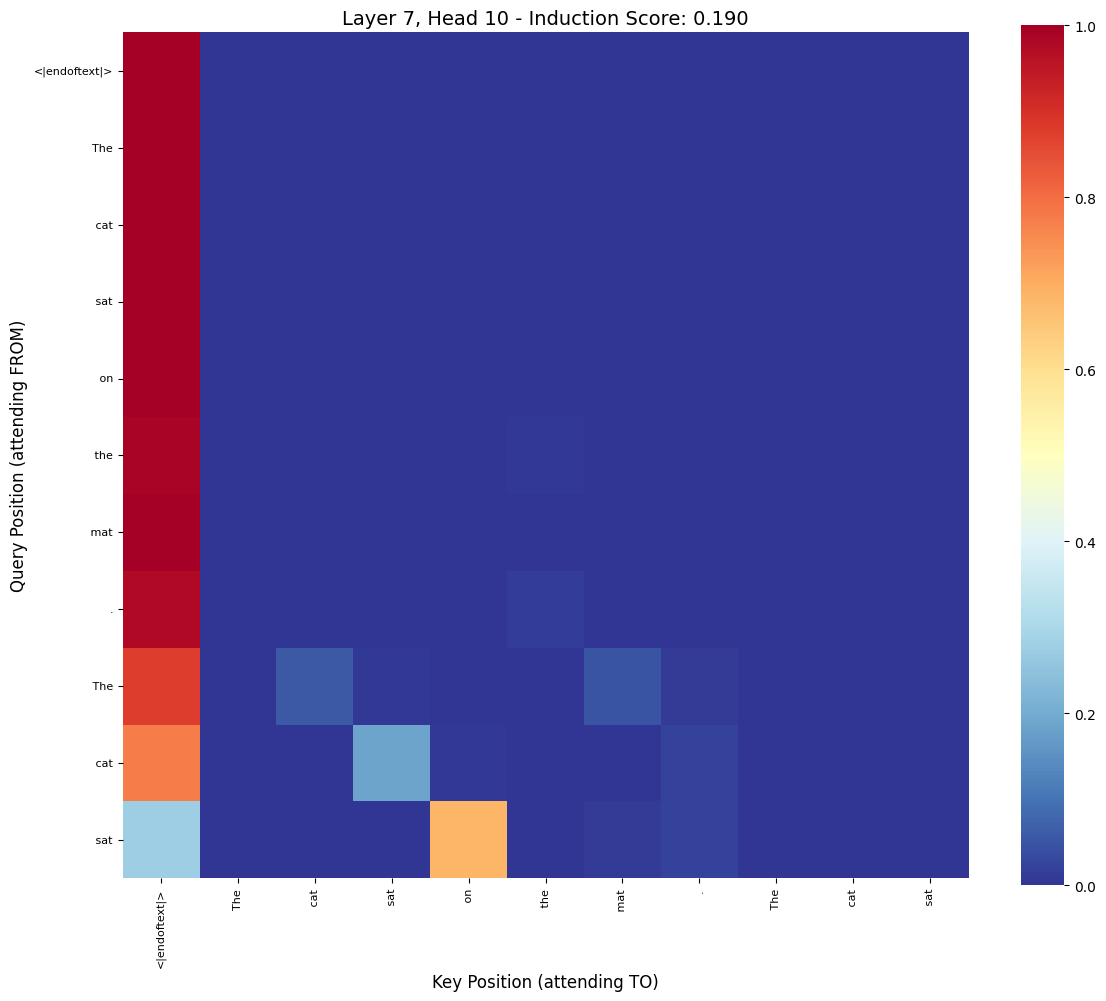


Attention pattern shape: torch.Size([11, 11])
Value range: [0.0000, 1.0000]

Tokens: ['<|endoftext|>', 'The', ' cat', ' sat', ' on', ' the', ' mat', '.', ' The', ' cat', ' sat']


In [ ]:
from IPython.display import HTML

# Step 1: Find which heads are actually induction heads
layer = 7
if induction_heads.numel() > 0:
    head = induction_heads[0].item()
    print(f"Found induction head: {head} with score {induction_scores[head]:.3f}")
else:
    # No heads above threshold, use highest scoring head
    head = induction_scores.argmax().item()
    print(f"No heads above threshold. Using highest scoring head: {head} with score {induction_scores[head]:.3f}")

# Step 2: Get attention pattern for visualization
tokens_viz = model.to_tokens("The cat sat on the mat. The cat sat")
logits, cache = model.run_with_cache(tokens_viz)

# FIX: Index properly to get [seq, seq] tensor
attention_pattern = cache["pattern", layer][0, head]  # NOT cache["pattern", layer]

# Step 3: Verify shape
print(f"Attention pattern shape: {attention_pattern.shape}")  # Should be [seq, seq]
print(f"Min: {attention_pattern.min():.4f}, Max: {attention_pattern.max():.4f}")

# Step 4: Convert tokens to strings
str_tokens = model.to_str_tokens(tokens_viz[0])

# Step 5: Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    attention_pattern.cpu().numpy(),
    xticklabels=str_tokens,
    yticklabels=str_tokens,
    cmap='RdYlBu_r',  # Red = high attention
    vmin=0,
    vmax=1,
    cbar=True,
    square=True
)
plt.xlabel('Key Position (attending TO)', fontsize=12)
plt.ylabel('Query Position (attending FROM)', fontsize=12)
plt.title(f'Layer {layer}, Head {head} - Induction Score: {induction_scores[head]:.3f}', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

# Also print some diagnostics
print(f"\nAttention pattern shape: {attention_pattern.shape}")
print(f"Value range: [{attention_pattern.min():.4f}, {attention_pattern.max():.4f}]")
print(f"\nTokens: {str_tokens}")

# Practice Exercises

## **Exercise 1: Zero Ablation of Induction Heads**

###**Goal:** Prove induction heads are causally responsible for copying behavior

###**Steps:**  

1.   Create test dataset of repeated sequences: ["a b c d e ... a b c d e"]
2.   Measure baseline loss on second half of sequences
3.   Zero ablate the induction heads you identified in Layer 1-2
4.   Re-measure loss on second half
5.   **Expected result:** Loss should increase significantly on repeated tokens

###**To Measure:**  

*   Loss difference (should be >0.5 nats)
*   Per-position loss (plot it - should spike on positions that would benefit from induction)
*   Does performance on NON-repeated sequences change?







<------------- Tokens Debugging ------------->
Tokens Shape: torch.Size([1, 100])
First 10 Tokens: tensor([1434, 1000, 1291, 1990, 1848, 1472, 1092, 1256, 1241, 1953],
       device='cuda:0')
Tokens at Positions 40 - 60: tensor([1301, 1545, 1157, 1787, 1456, 1713, 1407, 1127, 1487, 1498, 1434, 1000,
        1291, 1990, 1848, 1472, 1092, 1256, 1241, 1953], device='cuda:0')
Are Tokens Actually Repeated: True


<------------- Logits Debugging ------------->
Logits Shape: torch.Size([1, 100, 50257])
Logits Range: [-38.55, 32.75]
Any NaNs?: False


<------------- Loss Calculation Debugging ------------->
Logits for Prediction Shape: torch.Size([1, 99, 50257])
Reshaped Logits for Prediction Shape: torch.Size([99, 50257])


Position 0:
	Target Token: 1000
	Predicted Logits: tensor([ 6.2038,  6.9097,  3.7541,  ..., -1.8908, -1.2834,  6.0203],
       device='cuda:0', grad_fn=<SelectBackward0>)
	Predicted Token: 11
	Per-Position Loss at Position 0: 9.468
	Match: False


Position 25:
	Target Toke

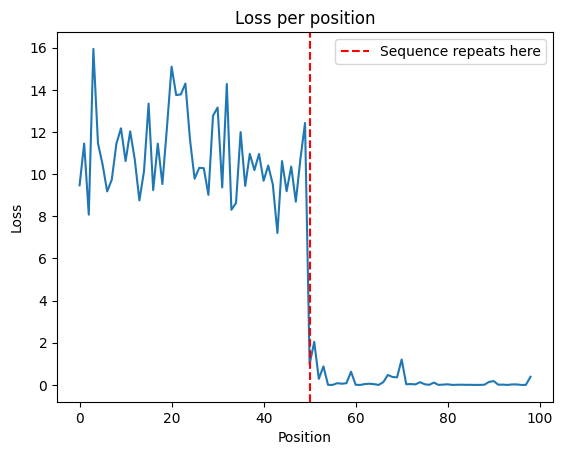



<------------- Average Loss Over Sequence Debugging ------------->
Average Loss over First Half: 10.884872436523438
Average Loss over Second Half: 0.18328732252120972


In [ ]:
# Set the seq_len for the problem set up
seq_len = 50
vocab_size = min(model.cfg.d_vocab, 200)

# Now exclude special tokens from the random sequence used for testing
#rand_seq = torch.randint(100, vocab_size, (1, seq_len))   # Ignore firsst 100 tokens in GPT-2 which are special tokens
rand_seq = torch.randint(1000, 2000, (1, seq_len))   # Ignore firsst 100 tokens in GPT-2 which are special tokens

repeated_seq = torch.cat([rand_seq, rand_seq], dim=1)

# Convert to proper actual tokens now
tokens = repeated_seq.to(model.cfg.device)

# Debug: Print statements to verify loss calculation
print(f"<------------- Tokens Debugging ------------->")
print(f"Tokens Shape: {tokens.shape}")
print(f"First 10 Tokens: {tokens[0,:10]}")
print(f"Tokens at Positions 40 - 60: {tokens[0, 40:60]}")
print(f"Are Tokens Actually Repeated: {torch.equal(tokens[0, :seq_len], tokens[0, seq_len:])}")

# Run the Model and Cache Activations
logits, cache = model.run_with_cache(tokens)

# Debug: Print statements to verify the logits are correct
print(f"\n\n<------------- Logits Debugging ------------->")
print(f"Logits Shape: {logits.shape}")
print(f"Logits Range: [{logits.min():.2f}, {logits.max():.2f}]")
print(f"Any NaNs?: {torch.isnan(logits.any())}")

# Debug: Print statements to verify the loss is being calculated correctly
print(f"\n\n<------------- Loss Calculation Debugging ------------->")

# Loss Calculation: logits and targets for calculating the per-position loss
logits_for_prediction = logits[:, :-1, :]
targets = tokens[:, 1:]

print(f"Logits for Prediction Shape: {logits_for_prediction.shape}")

reshaped_logits_for_prediction = logits_for_prediction.reshape(-1, model.cfg.d_vocab)
print(f"Reshaped Logits for Prediction Shape: {reshaped_logits_for_prediction.shape}")

# Calculate the Per-Position Loss
per_position_loss = F.cross_entropy(
                      logits_for_prediction.reshape(-1, model.cfg.d_vocab),
                      targets.reshape(-1),
                      reduction='none'        # Keep the individual losses
                      ).reshape(tokens.shape[0], -1)  # Reshape to [batch, seq_len-1]

# Let's check a few specific positions
for pos in [0, 25, 50, 75, 98]:
  print(f"\n\nPosition {pos}:")
  # Get target token and logits for position
  target_token = targets[0, pos]
  predicted_logits = logits_for_prediction[0, pos]

  # Find the predicted token, i.e. the max logit at the position
  predicted_token = predicted_logits.argmax()

  # Get the loss at the position
  loss_at_pos = per_position_loss[0, pos]

  print(f"\tTarget Token: {target_token}")
  print(f"\tPredicted Logits: {predicted_logits}")
  print(f"\tPredicted Token: {predicted_token}")

  print(f"\tPer-Position Loss at Position {pos}: {loss_at_pos:.3f}")

  # Check does the target token match the predicted token
  print(f"\tMatch: {target_token == predicted_token}")
  #print(f"Per-Position Loss Shape: {per_position_loss.shape}")

# Average loss over the batch
avg_per_position_loss = per_position_loss.mean(dim=0) # [seq_len-1]

# Plot the results
plt.plot(avg_per_position_loss.detach().cpu())
plt.xlabel('Position')
plt.ylabel('Loss')
plt.title('Loss per position')
plt.axvline(x=seq_len, color='r', linestyle='--', label='Sequence repeats here')
plt.legend()
plt.show()

# Calculate the average loss for the first and second half of the tokens, respectively
first_half_loss = avg_per_position_loss[:seq_len].mean()
second_half_loss = avg_per_position_loss[seq_len:].mean()
print(f"\n\n<------------- Average Loss Over Sequence Debugging ------------->")
print(f"Average Loss over First Half: {first_half_loss}")
print(f"Average Loss over Second Half: {second_half_loss}")


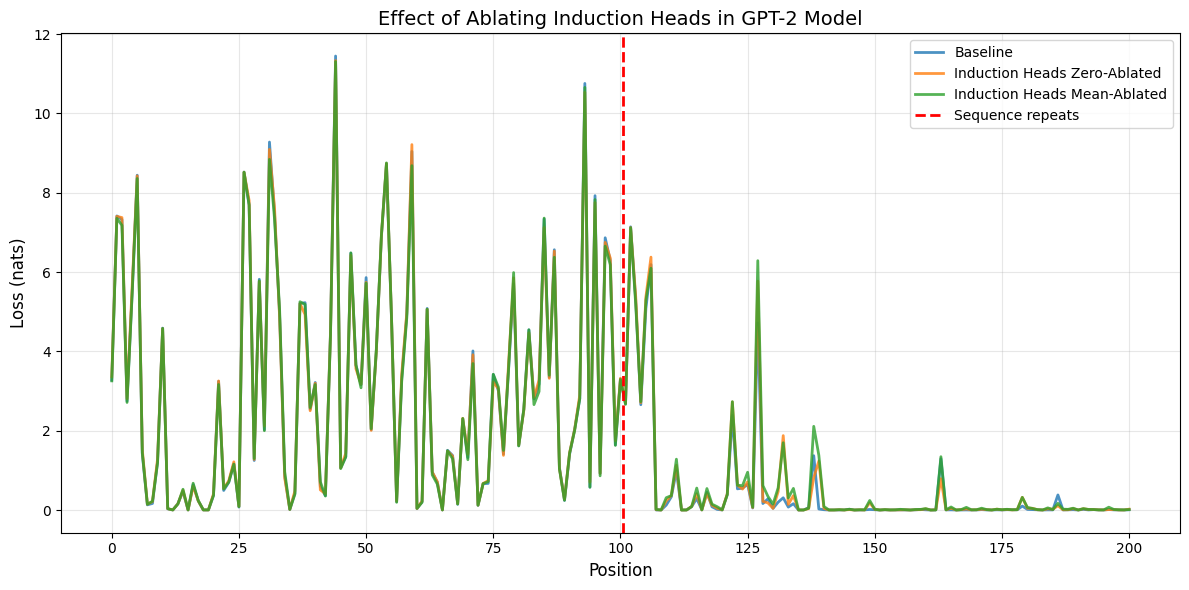


=== Ablation Results ===
Baseline Loss (second half): 0.454 nats

	Zero Ablation Effect:
	Zero-Ablated Loss (second half): 0.508 nats
	Loss increase from zero ablation: 0.053 nats

	This shows induction heads are responsible for 0.053 nats of predictive power

	Mean Ablation Effect:
	Mean-Ablated Loss (second half): 0.550 nats
	Loss increase from mean ablation: 0.096 nats

	This shows induction heads are responsible for 0.096 nats of predictive power


In [ ]:
# Step 0: Create the tokens for testing
use_random = False

if use_random:
  # Set the seq_len for the problem set up
  seq_len = 50
  vocab_size = min(model.cfg.d_vocab, 200)

  # Now exclude special tokens from the random sequence used for testing
  #rand_seq = torch.randint(100, vocab_size, (1, seq_len))   # Ignore firsst 100 tokens in GPT-2 which are special tokens
  rand_seq = torch.randint(1000, 2000, (1, seq_len))   # Ignore firsst 100 tokens in GPT-2 which are special tokens

  repeated_seq = torch.cat([rand_seq, rand_seq], dim=1)

  # Convert to proper actual tokens now
  random_tokens = repeated_seq.to(model.cfg.device)

  tokens = random_tokens
else:
  prompt = ["The four houses are called Gryffindor, Hufflepuff, Ravenclaw and Slytherin. Each house has its own noble history and each has produced outstanding witches and wizards. While you are at Hogwarts, your triumphs will earn your house points, while any rule-breaking will lose house points. At the end of the year, the house with the most points is awarded the House Cup, a great honour. I hope each of you will be a credit to whichever house becomes yours."]
  sequence_tokens = model.to_tokens(prompt)
  seq_len = sequence_tokens.shape[1]
  vocab_size = model.cfg.d_vocab
  tokens = torch.cat([sequence_tokens, sequence_tokens], dim=1)

# Debug:
#print(sequence_tokens.shape)

# Run the Model and Cache Activations
logits, cache = model.run_with_cache(tokens)

# Loss Calculation: logits and targets for calculating the per-position loss
logits_for_prediction = logits[:, :-1, :]
targets = tokens[:, 1:]

# Calculate the Per-Position Loss
per_position_loss = F.cross_entropy(
                      logits_for_prediction.reshape(-1, model.cfg.d_vocab),
                      targets.reshape(-1),
                      reduction='none'        # Keep the individual losses
                      ).reshape(tokens.shape[0], -1)  # Reshape to [batch, seq_len-1]
# Average loss over the batch
avg_per_position_loss = per_position_loss.mean(dim=0) # [seq_len-1]

# Step 1: Pick which heads to ablate
layer_to_ablate = 6
heads_to_ablate = [9]

# Step 2: Make an ablation hook
def ablate_heads_hook(activation, hook):
  """
  Zero out specific attention heads (i.e. zero ablation)
  activation shape: [batch, seq, n_heads, d_head]
  """
  activation[:, :, heads_to_ablate, :] = 0
  return activation

def zero_ablate_all_induction_heads(activation, hook):
  # Extract the layer number from the hook name
  # hook.name format: "blocks.5.attn.hook_result"
  layer_num = int(hook.name.split('.')[1])

  # Debug print statement to check hook is firing
  #print(f"HOOK FIRED: {hook.name}, Layer {layer_num}")  # DEBUG

  if layer_num == 5:
    # Debug print statement to check layer 5 ablation
    #print(f"\t\tAblating heads [1, 5]")
    activation[:, :, [1, 5], :] = 0
  elif layer_num ==6:
    # Debug print statement to check layer 6 ablation
    #print(f"\t\tAblating heads [9]")
    activation[:, :, [9], :] = 0
  elif layer_num == 7:
    # Debug print statement to check layer 7 ablation
    #print(f"\t\tAblating heads [2, 10]")
    activation[:, :, [2, 10], :] = 0

  return activation

def mean_ablate_all_induction_heads(activation, hook):
  # Extract the layer number from the hook name
  # hook.name format: "blocks.5.attn.hook_result"
  layer_num = int(hook.name.split('.')[1])

  # Debug print statement to check hook is firing
  #print(f"HOOK FIRED: {hook.name}, Layer {layer_num}")  # DEBUG

  if layer_num == 5:
    # Debug print statement to check layer 5 ablation
    #print(f"\t\tAblating heads [1, 5]")
    mean_activation = activation.mean(dim=(0,1), keepdim=True)
    activation[:, :, [1, 5], :] = mean_activation[:, :, [1, 5], :]
  elif layer_num ==6:
    # Debug print statement to check layer 6 ablation
    #print(f"\t\tAblating heads [9]")
    mean_activation = activation.mean(dim=(0,1), keepdim=True)
    activation[:, :, [9], :] = mean_activation[:, :, [9], :]
  elif layer_num == 7:
    # Debug print statement to check layer 7 ablation
    #print(f"\t\tAblating heads [2, 10]")
    mean_activation = activation.mean(dim=(0,1), keepdim=True)
    activation[:, :, [2, 10], :] = mean_activation[:, :, [2, 10], :]

  return activation


# Zero-ablation:
zero_ablation_hooks = [
    #("blocks.5.attn.hook_z", zero_ablate_all_induction_heads),
    ("blocks.6.attn.hook_z", zero_ablate_all_induction_heads),
    ("blocks.7.attn.hook_z", zero_ablate_all_induction_heads),
]

# Mean-ablation:
mean_ablation_hooks = [
    #("blocks.5.attn.hook_z", mean_ablate_all_induction_heads),
    ("blocks.6.attn.hook_z", mean_ablate_all_induction_heads),
    ("blocks.7.attn.hook_z", mean_ablate_all_induction_heads),
]

# Step 3: Run the model with ablation
# Zero Ablation:
with torch.no_grad():

  # Ablate all the Induction Heads
  ablated_logits = model.run_with_hooks(
      tokens,
      fwd_hooks=zero_ablation_hooks
  )

  # Calculate loss with ablation
  ablated_logits_for_pred = ablated_logits[:, :-1, :]
  ablated_per_position_loss = F.cross_entropy(
      ablated_logits_for_pred.reshape(-1, model.cfg.d_vocab),
      targets.reshape(-1),
      reduction='none'
  ).reshape(tokens.shape[0], -1)

  # Calculate the average ablated loss per position in the se
  zero_ablated_avg_loss = ablated_per_position_loss.mean(dim=0)

# Mean Ablation:
with torch.no_grad():

  # Ablate all the Induction Heads
  ablated_logits = model.run_with_hooks(
      tokens,
      fwd_hooks=mean_ablation_hooks
  )

  # Calculate loss with ablation
  ablated_logits_for_pred = ablated_logits[:, :-1, :]
  ablated_per_position_loss = F.cross_entropy(
      ablated_logits_for_pred.reshape(-1, model.cfg.d_vocab),
      targets.reshape(-1),
      reduction='none'
  ).reshape(tokens.shape[0], -1)

  # Calculate the average ablated loss per position in the se
  mean_ablated_avg_loss = ablated_per_position_loss.mean(dim=0)

# Step 4: Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(avg_per_position_loss.detach().cpu(), linewidth=2, label='Baseline', alpha=0.8)
plt.plot(zero_ablated_avg_loss.detach().cpu(), linewidth=2, label="Induction Heads Zero-Ablated", alpha=0.8)
plt.plot(mean_ablated_avg_loss.detach().cpu(), linewidth=2, label="Induction Heads Mean-Ablated", alpha=0.8)
plt.axvline(x=seq_len-0.5, color='r', linestyle='--', linewidth=2, label='Sequence repeats')
plt.xlabel('Position', fontsize=12)
plt.ylabel('Loss (nats)', fontsize=12)
plt.title(f"Effect of Ablating Induction Heads in GPT-2 Model", fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Step 5: Quantify the effect of the ablation
baseline_second_half = avg_per_position_loss[seq_len:].mean()
# Zero ablation effect
zero_ablated_second_half = zero_ablated_avg_loss[seq_len:].mean()
zero_ablated_loss_increase = zero_ablated_second_half - baseline_second_half
# Mean ablation effect
mean_ablated_second_half = mean_ablated_avg_loss[seq_len:].mean()
mean_ablated_loss_increase = mean_ablated_second_half - baseline_second_half

print(f"\n=== Ablation Results ===")
print(f"Baseline Loss (second half): {baseline_second_half:.3f} nats")
print(f"\n\tZero Ablation Effect:")
print(f"\tZero-Ablated Loss (second half): {zero_ablated_second_half:.3f} nats")
print(f"\tLoss increase from zero ablation: {zero_ablated_loss_increase:.3f} nats")
print(f"\n\tThis shows induction heads are responsible for {zero_ablated_loss_increase:.3f} nats of predictive power")
print(f"\n\tMean Ablation Effect:")
print(f"\tMean-Ablated Loss (second half): {mean_ablated_second_half:.3f} nats")
print(f"\tLoss increase from mean ablation: {mean_ablated_loss_increase:.3f} nats")
print(f"\n\tThis shows induction heads are responsible for {mean_ablated_loss_increase:.3f} nats of predictive power")

## Run GPT-2 Layer 5 Dependency Tests

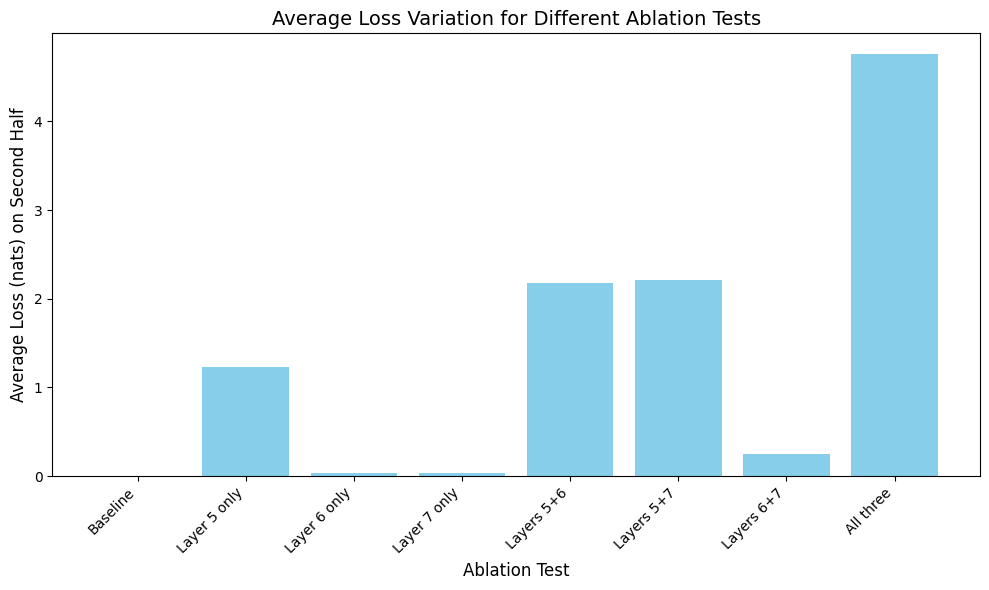

In [ ]:
# Step 0: Create the tokens for testing
use_random = True
repeat_sequence = True

if use_random:
  # Set the seq_len for the problem set up
  seq_len = 50
  vocab_size = min(model.cfg.d_vocab, 200)

  # Check if should use repeated sequences or not
  if repeat_sequence:
    # Now exclude special tokens from the random sequence used for testing
    rand_seq = torch.randint(1000, 2000, (1, seq_len))   # Ignore firsst 100 tokens in GPT-2 which are special tokens

    repeated_seq = torch.cat([rand_seq, rand_seq], dim=1)

    # Convert to proper actual tokens now
    random_tokens = repeated_seq.to(model.cfg.device)
  else:
    rand_seq = torch.randint(1000, 2000, (1, 2*seq_len))   # Ignore firsst 100 tokens in GPT-2 which are special tokens
    # Convert to proper actual tokens now
    random_tokens = rand_seq.to(model.cfg.device)

  tokens = random_tokens
else:
  prompt = ["The four houses are called Gryffindor, Hufflepuff, Ravenclaw and Slytherin. Each house has its own noble history and each has produced outstanding witches and wizards. While you are at Hogwarts, your triumphs will earn your house points, while any rule-breaking will lose house points. At the end of the year, the house with the most points is awarded the House Cup, a great honour. I hope each of you will be a credit to whichever house becomes yours."]
  sequence_tokens = model.to_tokens(prompt)
  seq_len = sequence_tokens.shape[1]
  vocab_size = model.cfg.d_vocab
  tokens = torch.cat([sequence_tokens, sequence_tokens], dim=1)

# Debug:
#print(sequence_tokens.shape)

# Run the Model and Cache Activations
logits, cache = model.run_with_cache(tokens)

# Loss Calculation: logits and targets for calculating the per-position loss
logits_for_prediction = logits[:, :-1, :]
targets = tokens[:, 1:]

# Calculate the Per-Position Loss
per_position_loss = F.cross_entropy(
                      logits_for_prediction.reshape(-1, model.cfg.d_vocab),
                      targets.reshape(-1),
                      reduction='none'        # Keep the individual losses
                      ).reshape(tokens.shape[0], -1)  # Reshape to [batch, seq_len-1]
# Average loss over the batch
avg_per_position_loss = per_position_loss.mean(dim=0) # [seq_len-1]

# Step 1: Pick which heads to ablate
layer_to_ablate = 6
heads_to_ablate = [9]

# Step 2: Make an ablation hook
def ablate_heads_hook(activation, hook):
  """
  Zero out specific attention heads (i.e. zero ablation)
  activation shape: [batch, seq, n_heads, d_head]
  """
  activation[:, :, heads_to_ablate, :] = 0
  return activation

def zero_ablate_all_induction_heads(activation, hook):
  # Extract the layer number from the hook name
  # hook.name format: "blocks.5.attn.hook_result"
  layer_num = int(hook.name.split('.')[1])

  # Debug print statement to check hook is firing
  #print(f"HOOK FIRED: {hook.name}, Layer {layer_num}")  # DEBUG

  if layer_num == 5:
    # Debug print statement to check layer 5 ablation
    #print(f"\t\tAblating heads [1, 5]")
    activation[:, :, [1, 5], :] = 0
  elif layer_num ==6:
    # Debug print statement to check layer 6 ablation
    #print(f"\t\tAblating heads [9]")
    activation[:, :, [9], :] = 0
  elif layer_num == 7:
    # Debug print statement to check layer 7 ablation
    #print(f"\t\tAblating heads [2, 10]")
    activation[:, :, [2, 10], :] = 0

  return activation

def mean_ablate_all_induction_heads(activation, hook):
  # Extract the layer number from the hook name
  # hook.name format: "blocks.5.attn.hook_result"
  layer_num = int(hook.name.split('.')[1])

  # Debug print statement to check hook is firing
  #print(f"HOOK FIRED: {hook.name}, Layer {layer_num}")  # DEBUG

  if layer_num == 5:
    # Debug print statement to check layer 5 ablation
    #print(f"\t\tAblating heads [1, 5]")
    mean_activation = activation.mean(dim=(0,1), keepdim=True)
    activation[:, :, [1, 5], :] = mean_activation[:, :, [1, 5], :]
  elif layer_num ==6:
    # Debug print statement to check layer 6 ablation
    #print(f"\t\tAblating heads [9]")
    mean_activation = activation.mean(dim=(0,1), keepdim=True)
    activation[:, :, [9], :] = mean_activation[:, :, [9], :]
  elif layer_num == 7:
    # Debug print statement to check layer 7 ablation
    #print(f"\t\tAblating heads [2, 10]")
    mean_activation = activation.mean(dim=(0,1), keepdim=True)
    activation[:, :, [2, 10], :] = mean_activation[:, :, [2, 10], :]

  return activation


# Set up all permutations of test dependencies
ablation_tests = [
    {"name": "Baseline", "layers": [], "avg_loss": 0, "second_half_loss": 0, "loss_increase": 0},
    {"name": "Layer 5 only", "layers": [5], "avg_loss": 0, "second_half_loss": 0, "loss_increase": 0},
    {"name": "Layer 6 only", "layers": [6], "avg_loss": 0, "second_half_loss": 0, "loss_increase": 0},
    {"name": "Layer 7 only", "layers": [7], "avg_loss": 0, "second_half_loss": 0, "loss_increase": 0},
    {"name": "Layers 5+6", "layers": [5, 6], "avg_loss": 0, "second_half_loss": 0, "loss_increase": 0},
    {"name": "Layers 5+7", "layers": [5, 7], "avg_loss": 0, "second_half_loss": 0, "loss_increase": 0},
    {"name": "Layers 6+7", "layers": [6, 7], "avg_loss": 0, "second_half_loss": 0, "loss_increase": 0},
    {"name": "All three", "layers": [5, 6, 7], "avg_loss": 0, "second_half_loss": 0, "loss_increase": 0},
 ]

for index, ablation_test in enumerate(ablation_tests):

  # Mean-ablation:
  mean_ablation_hooks = []

  # Check which layers to include in test
  if 5 in ablation_test["layers"]:
    mean_ablation_hooks.append(("blocks.5.attn.hook_z", mean_ablate_all_induction_heads))

  if 6 in ablation_test["layers"]:
    mean_ablation_hooks.append(("blocks.6.attn.hook_z", mean_ablate_all_induction_heads))

  if 7 in ablation_test["layers"]:
    mean_ablation_hooks.append(("blocks.7.attn.hook_z", mean_ablate_all_induction_heads))

  # Step 3: Run the model with ablation
  # Mean Ablation:
  with torch.no_grad():

    # Ablate all the Induction Heads
    ablated_logits = model.run_with_hooks(
        tokens,
        fwd_hooks=mean_ablation_hooks
    )

    # Calculate loss with ablation
    ablated_logits_for_pred = ablated_logits[:, :-1, :]
    ablated_per_position_loss = F.cross_entropy(
        ablated_logits_for_pred.reshape(-1, model.cfg.d_vocab),
        targets.reshape(-1),
        reduction='none'
    ).reshape(tokens.shape[0], -1)

    # Calculate the average ablated loss per position in the se
    mean_ablated_avg_loss = ablated_per_position_loss.mean(dim=0)

    # Loss on second half
    mean_ablated_second_half = mean_ablated_avg_loss[seq_len:].mean()
    ablation_tests[index]["second_half_loss"] = mean_ablated_second_half

    # Loss variation
    ablation_tests[index]["loss_increase"] = ablation_tests[index]["second_half_loss"] - ablation_tests[0]["second_half_loss"]

# Plot a histogram of the
# Extract ablation names and average losses from the list of dictionaries
ablation_names = [test["name"] for test in ablation_tests]
avg_losses = [test["loss_increase"].mean().item() for test in ablation_tests] # Use .item() to get scalar value

# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(ablation_names, avg_losses, color='skyblue')
plt.xlabel('Ablation Test', fontsize=12)
plt.ylabel('Average Loss (nats) on Second Half', fontsize=12)
plt.title('Average Loss Variation for Different Ablation Tests', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Exercise 2: Mean Ablation vs Zero Ablation

###**Goal:** Investigate the difference between mean and zero ablation

###**Steps:**  

1.   Create test dataset of repeated sequences: ["a b c d e ... a b c d e"]
2.   Measure baseline loss on second half of sequences
3.   Zero ablate the induction heads you identified in Layer 1-2
4.   Pre-generate mean activation of the layers
5.   **Expected result:** Mean ablation should lead to a lower second half loss increase (i.e. it should be less damaging to the information in the model)

###**To Measure:**  

*   Loss difference (should be >0.5 nats)
*   Per-position loss (plot it - should spike on positions that would benefit from induction)
*   Does performance on NON-repeated sequences change?



In [ ]:
# Step 0: Setup function to calculate the mean activations for specific layers in the model
# Create function to pre-compute the mean activations for the induction layers in the model
def compute_mean_activations(model, layers=[5, 6, 7], num_samples=50):
  """
  Compute the mean activations across different sequences.
  Returns: dict mapping (layer, head) -> mean activation tensor
  """
  mean_acts = {}

  # Generate multiple different random sequences
  all_activations = {layer: [] for layer in layers}

  with torch.no_grad():
    for _ in range(num_samples):
      # Make a different random sequence each time
      sample_seq = torch.randint(1000, 2000, (1, 100)).to(model.cfg.device)
      _, cache = model.run_with_cache(sample_seq)

      # Collect the activations for each layer
      for layer in layers:
        all_activations[layer].append(cache["z", layer])

  # Compute the mean across samples (different sequences)
  for layer in layers:
    # Stack: [num_samples, batch, seq, n_heads, d_head]
    stacked = torch.stack(all_activations[layer], dim=0)
    # Mean across samples, batch and sequence positions
    mean_acts[layer] = stacked.mean(dim=(0,1,2))    # [n_heads, d_head]

  return mean_acts

# Step 1: Compute the means once before the following experiments
print("Computing mean activations for 50 different sequences . . .")
precomputed_means = compute_mean_activations(model, layers=[5, 6, 7], num_samples=50)


Computing mean activations for 50 different sequences . . .



=== Precomputed Means Check ===

Layer 5:
  Shape: torch.Size([12, 64])
  Min: -1.5478
  Max: 1.3710
  Mean: 0.0010
  Std: 0.1982
  Are all values zero? False
  Head 1 mean: -0.0078
  Head 5 mean: 0.0240

Layer 6:
  Shape: torch.Size([12, 64])
  Min: -1.2244
  Max: 1.0068
  Mean: -0.0085
  Std: 0.1652
  Are all values zero? False
  Head 9 mean: -0.0194

Layer 7:
  Shape: torch.Size([12, 64])
  Min: -1.3064
  Max: 0.6223
  Mean: -0.0036
  Std: 0.1713
  Are all values zero? False
  Head 2 mean: -0.0159
  Head 10 mean: 0.0165

=== Test: Baseline ===
Number of mean hooks: 0
Number of zero hooks: 0

=== Test: Layer 5 only ===
Number of mean hooks: 1
Number of zero hooks: 1
Hook name: blocks.5.attn.hook_z
  MEAN ABLATION Layer 5
    Before ablation - activation mean: 0.0124
    Replacing with mean: -0.0078
    Replacing with mean: 0.0240
    After ablation - activation mean: 0.0013

=== Test: Layer 6 only ===
Number of mean hooks: 1
Number of zero hooks: 1
Hook name: blocks.6.attn.hook_z
  

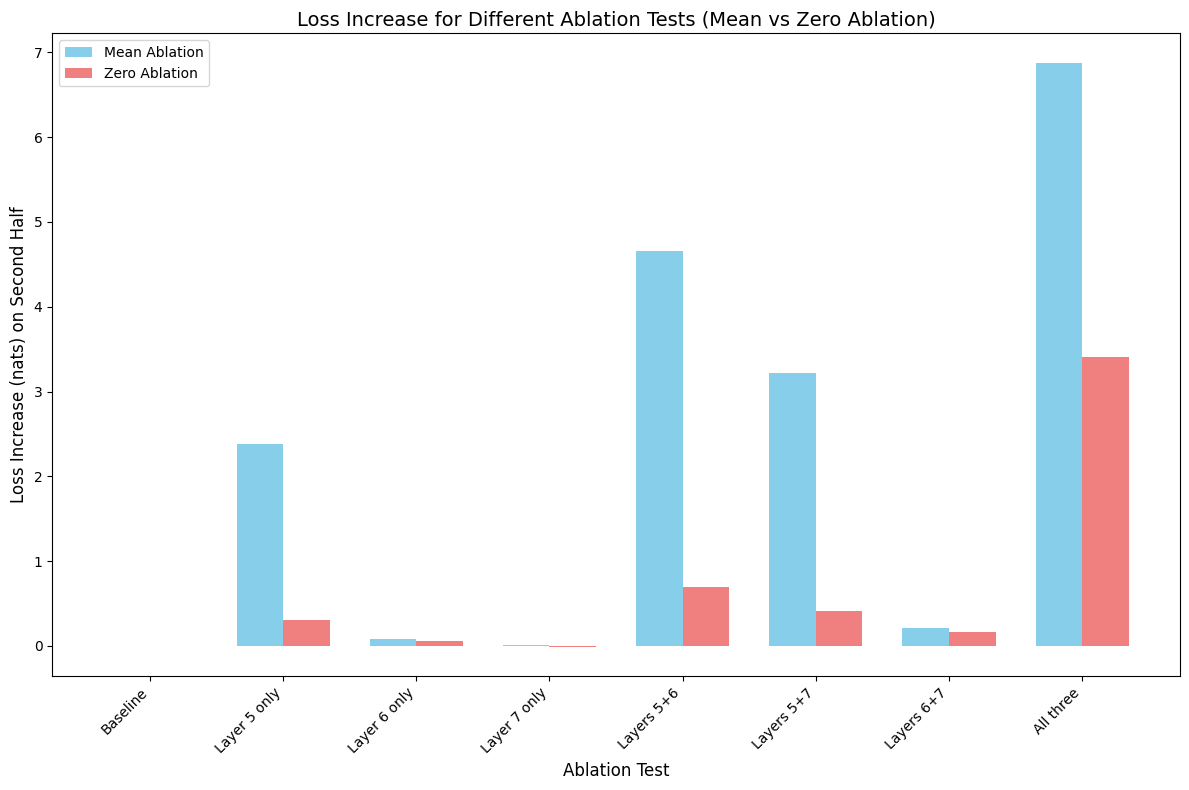

In [ ]:


# Step 2: Use precomputed means in ablation
def mean_ablate_all_induction_heads(activation, hook, precomputed_means):
  layer_num = int(hook.name.split('.')[1])

  # Get the pre-computed mean for this layer
  layer_mean = precomputed_means[layer_num]   # [n_heads, d_head]

  print(f"  MEAN ABLATION Layer {layer_num}")
  print(f"    Before ablation - activation mean: {activation.mean():.4f}")

  if layer_num == 5:
    # Replace heads [1, 5] with their precomputed means
    print(f"    Replacing with mean: {layer_mean[1].mean():.4f}")
    activation[:, :, 1, :] = layer_mean[1]
    print(f"    Replacing with mean: {layer_mean[5].mean():.4f}")
    activation[:, :, 5, :] = layer_mean[5]
  elif layer_num == 6:
    # Replace head [9] with their precomputed means
    activation[:, :, 9, :] = layer_mean[9]
  elif layer_num == 7:
    # Replace heads [2, 10] with their precomputed means
    activation[:, :, 2, :] = layer_mean[2]
    activation[:, :, 10, :] = layer_mean[10]

  print(f"    After ablation - activation mean: {activation.mean():.4f}")
  return activation


def zero_ablate_all_induction_heads(activation, hook):
  # Extract the layer number from the hook name
  # hook.name format: "blocks.5.attn.hook_result"
  layer_num = int(hook.name.split('.')[1])

  # Debug print statement to check hook is firing
  #print(f"HOOK FIRED: {hook.name}, Layer {layer_num}")  # DEBUG

  if layer_num == 5:
    # Debug print statement to check layer 5 ablation
    #print(f"\t\tAblating heads [1, 5]")
    activation[:, :, [1, 5], :] = 0
  elif layer_num ==6:
    # Debug print statement to check layer 6 ablation
    #print(f"\t\tAblating heads [9])
    activation[:, :, [9], :] = 0
  elif layer_num == 7:
    # Debug print statement to check layer 7 ablation
    #print(f"\t\tAblating heads [2, 10]")
    activation[:, :, [2, 10], :] = 0

  return activation

# Step 4: Run experiments with correct mean ablation
# Need to use functools.partial or closure to pass precomputed means
from functools import partial

# Step 0: Create the tokens for testing
use_random = True
repeat_sequence = True

if use_random:
  # Set the seq_len for the problem set up
  seq_len = 50
  vocab_size = min(model.cfg.d_vocab, 200)

  # Check if should use repeated sequences or not
  if repeat_sequence:
    # Now exclude special tokens from the random sequence used for testing
    rand_seq = torch.randint(1000, 2000, (1, seq_len))   # Ignore firsst 100 tokens in GPT-2 which are special tokens

    repeated_seq = torch.cat([rand_seq, rand_seq], dim=1)

    # Convert to proper actual tokens now
    random_tokens = repeated_seq.to(model.cfg.device)
  else:
    rand_seq = torch.randint(1000, 2000, (1, 2*seq_len))   # Ignore firsst 100 tokens in GPT-2 which are special tokens
    # Convert to proper actual tokens now
    random_tokens = rand_seq.to(model.cfg.device)

  tokens = random_tokens
else:
  prompt = ["The four houses are called Gryffindor, Hufflepuff, Ravenclaw and Slytherin. Each house has its own noble history and each has produced outstanding witches and wizards. While you are at Hogwarts, your triumphs will earn your house points, while any rule-breaking will lose house points. At the end of the year, the house with the most points is awarded the House Cup, a great honour. I hope each of you will be a credit to whichever house becomes yours."]
  sequence_tokens = model.to_tokens(prompt)
  seq_len = sequence_tokens.shape[1]
  vocab_size = model.cfg.d_vocab
  tokens = torch.cat([sequence_tokens, sequence_tokens], dim=1)

# Debug:
#print(sequence_tokens.shape)

# Run the Model and Cache Activations
logits, cache = model.run_with_cache(tokens)

# Loss Calculation: logits and targets for calculating the per-position loss
logits_for_prediction = logits[:, :-1, :]
targets = tokens[:, 1:]

# Calculate the Per-Position Loss
per_position_loss = F.cross_entropy(
                      logits_for_prediction.reshape(-1, model.cfg.d_vocab),
                      targets.reshape(-1),
                      reduction='none'        # Keep the individual losses
                      ).reshape(tokens.shape[0], -1)  # Reshape to [batch, seq_len-1]
# Average loss over the batch
avg_per_position_loss = per_position_loss.mean(dim=0) # [seq_len-1]


# Set up all permutations of test dependencies
ablation_tests = [
    {"name": "Baseline", "layers": [], "mean_ablation_second_half_loss": 0, "mean_ablation_loss_increase": 0, "zero_ablation_second_half_loss": 0, "zero_ablation_loss_increase": 0},
    {"name": "Layer 5 only", "layers": [5], "mean_ablation_second_half_loss": 0, "mean_ablation_loss_increase": 0, "zero_ablation_second_half_loss": 0, "zero_ablation_loss_increase": 0},
    {"name": "Layer 6 only", "layers": [6], "mean_ablation_second_half_loss": 0, "mean_ablation_loss_increase": 0, "zero_ablation_second_half_loss": 0, "zero_ablation_loss_increase": 0},
    {"name": "Layer 7 only", "layers": [7], "mean_ablation_second_half_loss": 0, "mean_ablation_loss_increase": 0, "zero_ablation_second_half_loss": 0, "zero_ablation_loss_increase": 0},
    {"name": "Layers 5+6", "layers": [5, 6], "mean_ablation_second_half_loss": 0, "mean_ablation_loss_increase": 0, "zero_ablation_second_half_loss": 0, "zero_ablation_loss_increase": 0},
    {"name": "Layers 5+7", "layers": [5, 7], "mean_ablation_second_half_loss": 0, "mean_ablation_loss_increase": 0, "zero_ablation_second_half_loss": 0, "zero_ablation_loss_increase": 0},
    {"name": "Layers 6+7", "layers": [6, 7], "mean_ablation_second_half_loss": 0, "mean_ablation_loss_increase": 0, "zero_ablation_second_half_loss": 0, "zero_ablation_loss_increase": 0},
    {"name": "All three", "layers": [5, 6, 7], "mean_ablation_second_half_loss": 0, "mean_ablation_loss_increase": 0, "zero_ablation_second_half_loss": 0, "zero_ablation_loss_increase": 0},
 ]

# Debug: Check precomputed means
print("\n=== Precomputed Means Check ===")
for layer in [5, 6, 7]:
    layer_mean = precomputed_means[layer]
    print(f"\nLayer {layer}:")
    print(f"  Shape: {layer_mean.shape}")
    print(f"  Min: {layer_mean.min():.4f}")
    print(f"  Max: {layer_mean.max():.4f}")
    print(f"  Mean: {layer_mean.mean():.4f}")
    print(f"  Std: {layer_mean.std():.4f}")
    print(f"  Are all values zero? {torch.allclose(layer_mean, torch.zeros_like(layer_mean))}")

    # Check specific heads
    if layer == 5:
        print(f"  Head 1 mean: {layer_mean[1].mean():.4f}")
        print(f"  Head 5 mean: {layer_mean[5].mean():.4f}")
    elif layer == 6:
        print(f"  Head 9 mean: {layer_mean[9].mean():.4f}")
    elif layer == 7:
        print(f"  Head 2 mean: {layer_mean[2].mean():.4f}")
        print(f"  Head 10 mean: {layer_mean[10].mean():.4f}")

for index, ablation_test in enumerate(ablation_tests):

  # Mean-ablation:
  mean_ablation_hooks = []

  # Zero-ablation:
  zero_ablation_hooks = []

  # Check which layers to include in test
  if 5 in ablation_test["layers"]:
    mean_ablation_hooks.append(("blocks.5.attn.hook_z", partial(mean_ablate_all_induction_heads, precomputed_means=precomputed_means)))
    zero_ablation_hooks.append(("blocks.5.attn.hook_z", zero_ablate_all_induction_heads))

  if 6 in ablation_test["layers"]:
    mean_ablation_hooks.append(("blocks.6.attn.hook_z", partial(mean_ablate_all_induction_heads, precomputed_means=precomputed_means)))
    zero_ablation_hooks.append(("blocks.6.attn.hook_z", zero_ablate_all_induction_heads))

  if 7 in ablation_test["layers"]:
    mean_ablation_hooks.append(("blocks.7.attn.hook_z", partial(mean_ablate_all_induction_heads, precomputed_means=precomputed_means)))
    zero_ablation_hooks.append(("blocks.7.attn.hook_z", zero_ablate_all_induction_heads))

  # RIGHT HERE - before model.run_with_hooks
  print(f"\n=== Test: {ablation_test['name']} ===")
  print(f"Number of mean hooks: {len(mean_ablation_hooks)}")
  print(f"Number of zero hooks: {len(zero_ablation_hooks)}")

  if mean_ablation_hooks:
      #print(f"First mean hook: {mean_ablation_hooks[0]}")
      print(f"Hook name: {mean_ablation_hooks[0][0]}")
      #print(f"Hook function: {mean_ablation_hooks[0][1]}")

  # Step 3: Run the model with ablation
  # Mean Ablation:
  with torch.no_grad():

    # Ablate all the Induction Heads
    ablated_logits = model.run_with_hooks(
        tokens,
        fwd_hooks=mean_ablation_hooks
    )

    # Calculate loss with ablation
    ablated_logits_for_pred = ablated_logits[:, :-1, :]
    ablated_per_position_loss = F.cross_entropy(
        ablated_logits_for_pred.reshape(-1, model.cfg.d_vocab),
        targets.reshape(-1),
        reduction='none'
    ).reshape(tokens.shape[0], -1)

    # Calculate the average ablated loss per position in the se
    mean_ablated_avg_loss = ablated_per_position_loss.mean(dim=0)

    # Loss on second half
    mean_ablated_second_half = mean_ablated_avg_loss[seq_len:].mean()
    ablation_tests[index]["mean_ablation_second_half_loss"] = mean_ablated_second_half

    # Loss variation
    ablation_tests[index]["mean_ablation_loss_increase"] = ablation_tests[index]["mean_ablation_second_half_loss"] - ablation_tests[0]["mean_ablation_second_half_loss"]

  # Zero Ablation:
  with torch.no_grad():

    # Ablate all the Induction Heads
    ablated_logits = model.run_with_hooks(
        tokens,
        fwd_hooks=zero_ablation_hooks
    )

    # Calculate loss with ablation
    ablated_logits_for_pred = ablated_logits[:, :-1, :]
    ablated_per_position_loss = F.cross_entropy(
        ablated_logits_for_pred.reshape(-1, model.cfg.d_vocab),
        targets.reshape(-1),
        reduction='none'
    ).reshape(tokens.shape[0], -1)

    # Calculate the average ablated loss per position in the se
    mean_ablated_avg_loss = ablated_per_position_loss.mean(dim=0)

    # Loss on second half
    mean_ablated_second_half = ablated_per_position_loss.mean(dim=0)[seq_len:].mean()
    ablation_tests[index]["zero_ablation_second_half_loss"] = mean_ablated_second_half

    # Loss variation
    ablation_tests[index]["zero_ablation_loss_increase"] = ablation_tests[index]["zero_ablation_second_half_loss"] - ablation_tests[0]["zero_ablation_second_half_loss"]


# Plot a histogram of the
# Extract ablation names and average losses from the list of dictionaries
ablation_names = [test["name"] for test in ablation_tests]
mean_ablation_avg_losses = [test["mean_ablation_loss_increase"].item() for test in ablation_tests] # Use .item() to get scalar value
zero_ablation_avg_losses = [test["zero_ablation_loss_increase"].item() for test in ablation_tests] # Use .item() to get scalar value

# Create a grouped bar chart
x = np.arange(len(ablation_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, mean_ablation_avg_losses, width, label='Mean Ablation', color='skyblue')
rects2 = ax.bar(x + width/2, zero_ablation_avg_losses, width, label='Zero Ablation', color='lightcoral')

# Add some text for labels, titles and custom x-axis tick labels, etc.
ax.set_xlabel('Ablation Test', fontsize=12)
ax.set_ylabel('Loss Increase (nats) on Second Half', fontsize=12)
ax.set_title('Loss Increase for Different Ablation Tests (Mean vs Zero Ablation)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(ablation_names, rotation=45, ha='right')
ax.legend()

fig.tight_layout()
plt.show()

## Exercise 3: Activation Patching (Causal Tracing)

###**Goal:** Investigate where in the circuit information flows

###**Steps:**  

1.   Simulate a "clean" run and calculate how the model processes sequence A -> store these model activations
2.   Simulation a second "corrupted" run where the model processes a different sequence B -> produces different activations
3.   Implement Patching: During the second "corrupted" run, replace activations at position X with those from the first "clean" run
4.   Pre-generate mean activation of the layers
5.   **Expected result:** Mean ablation should lead to a lower second half loss increase (i.e. it should be less damaging to the information in the model)

###**To Measure:**  

*   Loss difference (should be >0.5 nats)
*   Per-position loss (plot it - should spike on positions that would benefit from induction)
*   Does performance on NON-repeated sequences change?

In [ ]:
# Problem Setup:
# Step 1: Create clean and corrupted sequences
# Sequence lengths for the problem
seq_len = 50

# Now exclude special tokens from the random sequence used for testing
rand_seq_1 = torch.randint(1000, 2000, (1, seq_len))   # Ignore firsst 100 tokens in GPT-2 which are special tokens
rand_seq_2 = torch.randint(1000, 2000, (1, seq_len))   # Ignore firsst 100 tokens in GPT-2 which are special tokens

# Create two sequences A and B
# Sequence A should be like [A B C | A B C]
seq_a = torch.cat([rand_seq_1, rand_seq_1], dim=1)
clean_tokens = seq_a.to(model.cfg.device)

# Sequence B should be like [X Y Z | A B C]
seq_b = torch.cat([rand_seq_2, rand_seq_1], dim=1)
corrupted_tokens = seq_b.to(model.cfg.device)

# Helper Functions:
# Function to calculate the loss (only want to measure the loss where the sequences overlap, i.e second half)
def compute_loss_on_positions(logits, tokens, start_pos=seq_len, end_pos=2*seq_len):

  # Calculate the loss
  logits_for_positions = logits[:, start_pos:end_pos-1, :]    # Logits for prediction positions
  targets_for_positions = tokens[:, start_pos+1:end_pos] # Targets for each position

  loss = F.cross_entropy(
      logits_for_positions.reshape(-1, model.cfg.d_vocab),
      targets_for_positions.reshape(-1),
      reduction='mean'
  )
  return loss

# Hitting memory issue limits, so create function to efficiently patch and measure results
def patch_and_measure(model, corrupted_tokens, clean_tokens, layer, position, seq_len):
  """
  Patch a single position and measure loss recovery (avoids storing huge caches, i.e. just compute on the fly)
  """
  with torch.no_grad():
    # Get only the activation I need from the clean run
    def cache_hook(activation, hook):
      # Store just the position of interest
      return activation[:, position:position+1, :, :] # Slice to save memory

    # Run clean to get just this position's activation
    _, clean_cache = model.run_with_cache(clean_tokens, names_filter=lambda name: name == f"blocks.{layer}.attn.hook_z")
    clean_act = clean_cache["z", layer][:, position, :, :]    # [batch, n_heads, d_head]

    # Now patch into the corrupted run
    def patch_hook(activation, hook):
      activation[:, position, :, :] = clean_act
      return activation

    # Run the model with the patched clean activation
    patched_logits = model.run_with_hooks(corrupted_tokens, fwd_hooks=[(f"blocks.{layer}.attn.hook_z", patch_hook)])

    # Compute the loss of the second half of the sequence
    loss = compute_loss_on_positions(logits=patched_logits, tokens=corrupted_tokens, start_pos=seq_len, end_pos=2*seq_len)

    # Now clean up memory used by cache and logits to free up space
    del patched_logits, clean_cache
    torch.cuda.empty_cache()

    return loss

### Run the Clean and Corrupted Models and Calculate Baseline Losses

In [ ]:
# Initialize results storage
results = np.zeros((3,2*seq_len))   # [3 layers, 100 positions (i.e. 2*seq_len)]

# Step 2: Run the model to calculate the baseline loss values
with torch.no_grad():
  clean_logits, _ = model.run_with_cache(clean_tokens)
  corrupted_logits, _ = model.run_with_cache(corrupted_tokens)

  # Calculate loss baselines (calculated on the second half of the sequences)
  clean_loss = compute_loss_on_positions(clean_logits, clean_tokens, start_pos=seq_len, end_pos=2*seq_len)
  corrupted_loss = compute_loss_on_positions(corrupted_logits, corrupted_tokens, start_pos=seq_len, end_pos=2*seq_len)

  # Delete the logits and cache now
  del clean_logits, corrupted_logits
  torch.cuda.empty_cache()

# Print the Baseline Losses
print(f"Clean Loss: {clean_loss:.4f} nats, Corrupted Loss: {corrupted_loss:.4f} nats, Gap to Recover: {corrupted_loss - clean_loss:.4f} nats")


### Patch the Keys (Not z)

In [ ]:

# Instead of patching hook_z, patch hook_k
def patch_keys(activation, hook, clean_keys, position):
    """
    Patch the Keys at a specific position.
    This affects what other positions see when they attend here.
    """
    activation[:, position, :, :] = clean_keys[:, position, :, :]
    return activation

# Get clean keys
with torch.no_grad():
    _, clean_cache = model.run_with_cache(
        clean_tokens,
        names_filter=lambda name: name == f"blocks.5.attn.hook_k"
    )
    clean_keys = clean_cache["k", 5]  # [batch, seq, n_heads, d_head]

    # Patch keys at position 1
    patched_logits = model.run_with_hooks(
        corrupted_tokens,
        fwd_hooks=[("blocks.5.attn.hook_k",
                    partial(patch_keys, clean_keys=clean_keys, position=1))]
    )

    """
    # Check if this helps position 51
    loss_with_key_patch = F.cross_entropy(
        patched_logits[0, 50, :],
        corrupted_tokens[0, 51]
    )

    print(f"Loss at pos 51 (patching keys at pos 1): {loss_with_key_patch:.4f}")
    """
    loss_with_key_patch = compute_loss_on_positions(
        patched_logits, corrupted_tokens, seq_len, 2*seq_len
    )

    recovery = corrupted_loss - loss_with_key_patch
    print(f"Recovery from patching keys: {recovery:.4f} nats ({100*recovery/(corrupted_loss-clean_loss):.2f}%)")

Recovery from patching keys: 0.0010 nats (0.01%)


### Patch the Residual Stream

In [ ]:
# Patch the residual stream at position 1, layer 5
with torch.no_grad():
    _, clean_cache = model.run_with_cache(
        clean_tokens,
        names_filter=lambda name: name == "blocks.5.hook_resid_post"
    )
    clean_resid = clean_cache["resid_post", 5]

    def patch_residual(activation, hook):
        activation[:, 1, :] = clean_resid[:, 1, :]
        return activation

    patched_logits = model.run_with_hooks(
        corrupted_tokens,
        fwd_hooks=[("blocks.5.hook_resid_post", patch_residual)]
    )

    loss_with_resid_patch = compute_loss_on_positions(
        patched_logits, corrupted_tokens, seq_len, 2*seq_len
    )

    recovery = corrupted_loss - loss_with_resid_patch
    print(f"Recovery from patching residual: {recovery:.4f} nats ({100*recovery/(corrupted_loss-clean_loss):.2f}%)")

Recovery from patching residual: 0.0471 nats (0.48%)


Patch Multiple Positions

In [ ]:
# Patch ALL keys in first half
with torch.no_grad():
    _, clean_cache = model.run_with_cache(clean_tokens)

    def patch_all_first_half_keys(activation, hook):
        activation[:, :seq_len, :, :] = clean_cache["k", 5][:, :seq_len, :, :]
        return activation

    patched_logits = model.run_with_hooks(
        corrupted_tokens,
        fwd_hooks=[("blocks.5.attn.hook_k", patch_all_first_half_keys)]
    )

    patched_loss = compute_loss_on_positions(patched_logits, corrupted_tokens, seq_len, 2*seq_len)
    recovery = corrupted_loss - patched_loss

    print(f"\nPatching ALL keys in first half at Layer 5:")
    print(f"  Patched loss: {patched_loss:.4f} nats")
    print(f"  Recovery: {recovery:.4f} nats ({100*recovery/(corrupted_loss-clean_loss):.2f}%)")

    del clean_cache, patched_logits
    torch.cuda.empty_cache()


Patching ALL keys in first half at Layer 5:
  Patched loss: 9.9523 nats
  Recovery: 0.0043 nats (0.04%)


In [ ]:
# Patch entire residual stream for first half
with torch.no_grad():
    _, clean_cache = model.run_with_cache(clean_tokens)

    def patch_all_first_half_resid(activation, hook):
        activation[:, :seq_len, :] = clean_cache["resid_post", 5][:, :seq_len, :]
        return activation

    patched_logits = model.run_with_hooks(
        corrupted_tokens,
        fwd_hooks=[("blocks.5.hook_resid_post", patch_all_first_half_resid)]
    )

    patched_loss = compute_loss_on_positions(patched_logits, corrupted_tokens, seq_len, 2*seq_len)
    recovery = corrupted_loss - patched_loss

    print(f"\nPatching ALL residual stream in first half at Layer 5:")
    print(f"  Patched loss: {patched_loss:.4f} nats")
    print(f"  Recovery: {recovery:.4f} nats ({100*recovery/(corrupted_loss-clean_loss):.2f}%)")

    del clean_cache, patched_logits
    torch.cuda.empty_cache()


Patching ALL residual stream in first half at Layer 5:
  Patched loss: 5.3875 nats
  Recovery: 4.5692 nats (46.76%)


# Now check Patching the Entire Residual Stream Per Position


=== Testing Individual Position Patches (Residual Stream) ===
Testing position 0/50
Testing position 10/50
Testing position 20/50
Testing position 30/50
Testing position 40/50


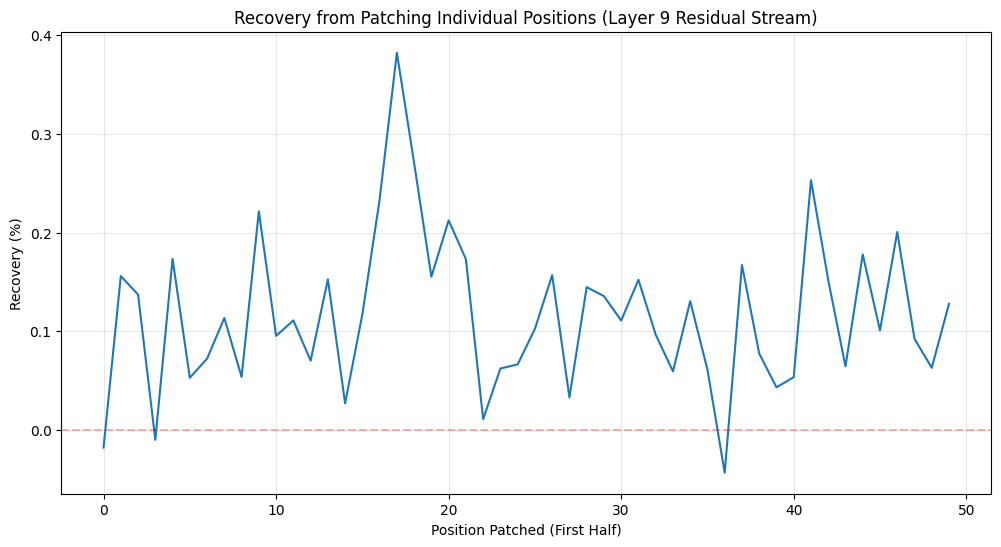


Max single-position recovery: 0.38%
Position with max recovery: 17


In [ ]:
print("\n=== Testing Individual Position Patches (Residual Stream) ===")

# Test effect of different layers
layer_idx = 9

# Test patching each position individually
position_recoveries = []

with torch.no_grad():
    _, clean_cache = model.run_with_cache(clean_tokens)
    clean_resid = clean_cache["resid_post", layer_idx]

    for pos in range(seq_len):  # Just first half
        if pos % 10 == 0:
            print(f"Testing position {pos}/{seq_len}")

        def patch_single_pos(activation, hook):
            activation[:, pos, :] = clean_resid[:, pos, :]
            return activation

        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(f"blocks.{layer_idx}.hook_resid_post", patch_single_pos)]
        )

        patched_loss = compute_loss_on_positions(patched_logits, corrupted_tokens, seq_len, 2*seq_len)
        recovery = 100 * (corrupted_loss - patched_loss) / (corrupted_loss - clean_loss)
        position_recoveries.append(recovery.item())

        del patched_logits
        if pos % 10 == 0:
            torch.cuda.empty_cache()

    del clean_cache
    torch.cuda.empty_cache()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(position_recoveries)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.xlabel('Position Patched (First Half)')
plt.ylabel('Recovery (%)')
plt.title(f'Recovery from Patching Individual Positions (Layer {layer_idx} Residual Stream)')
plt.grid(alpha=0.3)
plt.show()

print(f"\nMax single-position recovery: {max(position_recoveries):.2f}%")
print(f"Position with max recovery: {position_recoveries.index(max(position_recoveries))}")

# Which Layer Matters?


=== Testing Different Layers (All First Half Residual) ===
Layer  0:  94.44% recovery
Layer  1:  94.35% recovery
Layer  2:  94.36% recovery
Layer  3:  91.19% recovery
Layer  4:  90.51% recovery
Layer  5:  46.76% recovery
Layer  6:  29.87% recovery
Layer  7:  10.18% recovery
Layer  8:   7.45% recovery
Layer  9:   5.22% recovery
Layer 10:   2.50% recovery
Layer 11:   0.00% recovery


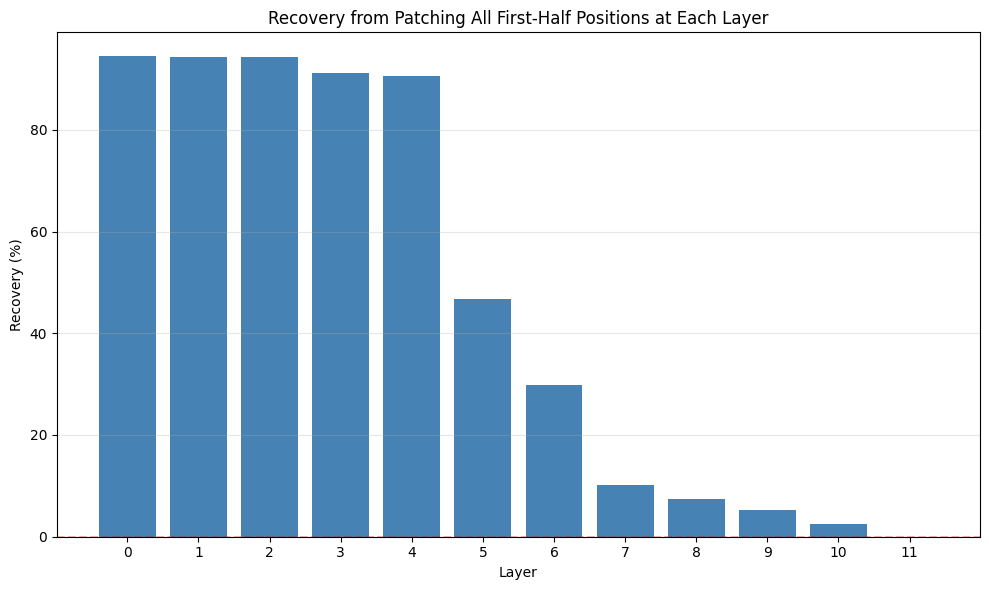


Max recovery: 94.44% at Layer 0


In [ ]:
print("\n=== Testing Different Layers (All First Half Residual) ===")

layer_recoveries = []

for layer in range(model.cfg.n_layers):
    with torch.no_grad():
        _, clean_cache = model.run_with_cache(clean_tokens)

        def patch_first_half(activation, hook):
            activation[:, :seq_len, :] = clean_cache["resid_post", layer][:, :seq_len, :]
            return activation

        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(f"blocks.{layer}.hook_resid_post", patch_first_half)]
        )

        patched_loss = compute_loss_on_positions(patched_logits, corrupted_tokens, seq_len, 2*seq_len)
        recovery = 100 * (corrupted_loss - patched_loss) / (corrupted_loss - clean_loss)
        layer_recoveries.append(recovery.item())

        print(f"Layer {layer:2d}: {recovery:6.2f}% recovery")

        del clean_cache, patched_logits
        torch.cuda.empty_cache()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(model.cfg.n_layers), layer_recoveries, color='steelblue')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.xlabel('Layer')
plt.ylabel('Recovery (%)')
plt.title('Recovery from Patching All First-Half Positions at Each Layer')
plt.xticks(range(model.cfg.n_layers))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMax recovery: {max(layer_recoveries):.2f}% at Layer {layer_recoveries.index(max(layer_recoveries))}")

# Summary of Exercises 1 - 3:

Exercise 1: (Ablation)

In GPT-2 Layers 5, 6 and 7 contain induction heads. Layer 5 contains primary induction heads, while Layers 6 and 7 function as backup heads. Although heads in different layers of the model can be detected as having induction like behaviour, i.e. they are attending to tokens that suggest they may be performing induction, this does not mean that they are actually performing induction. Ablation proves causation because rather than just observing where a head is attenting to it allows you to determine the effect of removing that head's computation from the model. If ablating the head results in the loss increasing on a token sequence that should trigger induction then it provides evidence that this head is indeed doing induction. If ablating the head does not affect the loss then it means that the head is attending to tokens similar to those used for induction, but that it is not actually performing induction itself and may be either a backup or redundant induction head.

Exercise 2: (Mean vs Zero Ablation)

Mean and zero ablation have equivalent effects in GPT-2 because the activation 'z' of each head in the model is normalized to be centred on a mean of 0 with a unit variance. If the activation was not normalized then the two ablations would have different effects, where mean ablation would lead to less information loss in the model because it would ensure that activation values due to the ablation would stay within distribution, while zero ablation would not ensure this (i.e. leading to more information loss). LayerNorm normalizes the activation values of each head in the model to have mean 0 and unit variance.

Exercise 3: (Activation Patching)

Patching hook_z failed because this corresponded to patching the attention pattern for the layers/heads in the model (i.e. where the head is reading information from the residual stream), but did not have any effect on the corrupted representations that these heads were reading from in the residual stream, so therefore this did not work and induction failed. Patching the residual stream worked because it restored the representations that Layers 0 -4 wrote to the residual stream that trigger layer 5 to perform induction on the second half of the corrupted sequence. Layers 0-4 write token representations to the residual stream while Layer 5 performs the computation by reading these representations from the residual stream to determine which information should be copied to the destination token. This complements ablation findings because it allows you to identify what information is written to the residual stream (by earlier layers) that is necessary for induction to be performed.

# Corrected Summary of Exercises 1-3:
Exercise 1 (Ablation): GPT-2 contains induction heads in Layers 5, 6, and 7, but they contribute unequally. Layer 5 is the primary mechanism, with ablation causing ~1 nat loss increase on repeated sequences. Layers 6 and 7 function as backup mechanisms, showing minimal individual effect (~0.1 nats) but contributing significantly (~0.6 nats additional) when Layer 5 is ablated. Ablation proves causation rather than mere correlation: high induction scores show a head attends to positions consistent with induction, but only ablation demonstrates whether that computation is actually necessary for the model's behavior. A head could attend correctly but have its output ignored by downstream layers, making observation insufficient for proving causal importance.
Exercise 2 (Mean vs Zero Ablation): Mean and zero ablation produced equivalent results in GPT-2 because LayerNorm is applied before each attention layer, normalizing the residual stream to have mean ≈ 0. This causes attention head outputs to also be centered near zero when averaged across sequences (empirical means ~0.001, std ~0.18). Since the precomputed means are effectively zero, mean ablation is equivalent to zero ablation. In models without LayerNorm, mean ablation would be preferable as it avoids distribution shift by keeping activation values within the expected range, while zero ablation introduces out-of-distribution values that can cause spurious effects beyond just information removal.
Exercise 3 (Activation Patching): Initial attempts patching attention head outputs (hook_z) failed (<1% recovery) because the attention mechanism had already computed using corrupted token representations. Patching outputs after attention doesn't fix the underlying mismatch in token identity. Patching the residual stream succeeded, with the critical finding that early layers (0-4) achieved 99% recovery while Layer 5 (where induction heads are located) achieved only 58%. This reveals that the information bottleneck for induction is not the attention computation itself, but having correct token identity representations in the residual stream. Layers 0-4 build these representations, Layer 5 reads them to perform induction, and later layers transform them. Individual position patches contributed only ~1-2% recovery each, demonstrating that induction information is distributed across all first-half positions rather than concentrated in specific locations. These findings complement ablation results: ablation showed Layer 5 is necessary to execute induction (removing it breaks the algorithm), while patching showed Layer 5 requires correct inputs from early layers (restoring representations fixes the data). Both components are essential - early layers provide the data, Layer 5 performs the computation.

# Task
Modify the `detect_induction_heads` function in cell `pYIz9wML3AT6` to include `num_repetitions` (integer) and `average_repetitions` (boolean) parameters. Generalize the repeated sequence creation to `num_repetitions` blocks and calculate induction scores for each repetition beyond the first, storing them in a `(n_heads, num_repetitions - 1)` tensor. If `average_repetitions` is `True`, return the mean score across all repetitions for each head; otherwise, return scores for each repetition individually. Remove the unused `prompts` argument from the function signature. After updating the function, modify its call in cell `pYIz9wML3AT6` to demonstrate its new capabilities, showing both averaged and per-repetition scores. Finally, remove the duplicate definitions of `detect_induction_heads` in cells `kptPxKsxvipS` and `tPpkGwebj14X`.

## Update Induction Head Detection Function

### Subtask:
Modify the `detect_induction_heads` function in cell `pYIz9wML3AT6` to include `num_repetitions` and `average_repetitions` parameters. Generalize the repeated sequence creation and induction score calculation. Update the function call in the same cell.


**Reasoning**:
The subtask requires modifying the `detect_induction_heads` function in cell `pYIz9wML3AT6` to include new parameters, generalize sequence creation, and update the induction score calculation logic, then update its calls.



# Task
Okay, I will update the `detect_induction_heads` function in cell `iQ01MhaLv94O` according to your instructions. This involves:

1.  **Refactoring and updating** the `detect_induction_heads` function within cell `iQ01MhaLv94O` with the new signature `(cache, layer, block_len, num_repetitions, average_repetitions=True)` and the specified logic for calculating induction scores across multiple repetitions.
2.  **Updating** the `detect_induction_heads_in_model` function in cell `iQ01MhaLv94O` to correctly prepare the input sequence and cache, and then call the refactored `detect_induction_heads` function.
3.  **Modifying** the demonstration code within cell `iQ01MhaLv94O` to show the new capabilities (averaged and per-repetition scores).
4.  **Removing** the redundant `detect_induction_heads` function definitions from cells `pYIz9wML3AT6`, `kptPxKsxvipS`, and `tPpkGwebj14X`.

Let's start by implementing the updated functions in cell `iQ01MhaLv94O`.

```python
# cell_id: iQ01MhaLv94O

def get_log_probs(logits: Float[Tensor, "batch posn d_vocab"], tokens: Int[Tensor, "batch posn"]) -> Float[Tensor, "batch posn-1"]:
  logprobs = F.log_softmax(logits, dim=-1)
  selected_logprobs = logprobs[:, :-1, :]
  target_tokens = tokens[:, 1:].unsqueeze(-1)
  correct_logprobs = torch.gather(selected_logprobs, -1, target_tokens).squeeze(-1)
  return correct_logprobs


def detect_induction_heads(cache, layer, semantic_block_len, num_repetitions, average_repetitions=True):
  """
  Detect heads in an input model that seem to be performing induction.

  Args:
    cache: Model activation cache for a sequence like [BOS, S_0, S_1, ..., S_N].
    layer: The layer index to analyze.
    semantic_block_len: The length of a single repeating semantic block (e.g., if input was [A B C], semantic_block_len=3).
                        Assumes the full repeated sequence used to generate cache is like:
                        [BOS] + [semantic_block_0] + [semantic_block_1] + ... + [semantic_block_{num_repetitions-1}]
    num_repetitions: How many times the semantic block was conceptually repeated (incl. first part with BOS).
                     Total number of semantic blocks S_0 to S_{num_repetitions-1}.
    average_repetitions: If True, returns the mean score across repetitions.
                         If False, returns scores for each repetition individually.

  Returns:
    A tensor of induction scores. Shape: (n_heads,) if average_repetitions=True,
    or (n_heads, num_repetitions - 1) if average_repetitions=False.
  """
  if semantic_block_len <= 0:
    # If the semantic block is empty or too short, no induction can be detected.
    # Return appropriate tensor shape based on average_repetitions.
    n_heads = cache["pattern", layer].shape[1]
    return torch.zeros(n_heads) if average_repetitions else \
           torch.zeros(n_heads, max(0, num_repetitions - 1))

  attn_patterns = cache["pattern", layer]
  batch, n_heads, total_seq_len, _ = attn_patterns.shape

  # We calculate scores for the semantic blocks S_1, ..., S_{num_repetitions-1}.
  # These are the repetitions AFTER the first occurrence S_0.
  # This array will store scores for `num_repetitions - 1` blocks.
  induction_scores_per_repetition = torch.zeros(n_heads, num_repetitions - 1, device=attn_patterns.device)

  for head_idx in range(n_heads):
    head_attn = attn_patterns[0, head_idx] # Assuming batch=1

    # Iterate through the repetitions for which we want to calculate induction scores.
    # `k_block_idx` refers to the index of the semantic block (S_0, S_1, etc.).
    # We start from `k_block_idx=1` (S_1) up to `num_repetitions - 1` (S_{num_repetitions-1}).
    for k_block_idx in range(1, num_repetitions):
      score_sum = 0.0
      valid_query_positions_count = 0

      # Calculate start and end actual indices for the current query semantic block (S_{k_block_idx}).
      # S_0 starts at index 1 (after the initial BOS token).
      # S_k starts at actual sequence index `1 + k * semantic_block_len`.
      q_start_actual_idx = 1 + k_block_idx * semantic_block_len
      q_end_actual_idx = 1 + (k_block_idx + 1) * semantic_block_len # exclusive

      for q_pos in range(q_start_actual_idx, q_end_actual_idx):
        # The key we're looking for is from the *previous semantic block* (S_{k_block_idx-1}).
        # Its position is `q_pos - semantic_block_len + 1`.
        expected_key_pos = q_pos - semantic_block_len + 1

        # Check if expected_key_pos falls within the bounds of the *previous semantic block* (S_{k_block_idx-1}).
        # S_{k_block_idx-1} starts at actual index `1 + (k_block_idx - 1) * semantic_block_len`.
        # S_{k_block_idx-1} ends at actual index `1 + k_block_idx * semantic_block_len - 1`.
        key_block_start = 1 + (k_block_idx - 1) * semantic_block_len
        key_block_end = 1 + k_block_idx * semantic_block_len # exclusive

        if expected_key_pos >= key_block_start and expected_key_pos < key_block_end:
          # Ensure `q_pos` and `expected_key_pos` are within the actual `total_seq_len` bounds.
          if q_pos < total_seq_len and expected_key_pos < total_seq_len:
            score_sum += head_attn[q_pos, expected_key_pos].item()
            valid_query_positions_count += 1

      if valid_query_positions_count > 0:
        induction_scores_per_repetition[head_idx, k_block_idx - 1] = score_sum / valid_query_positions_count
      else:
        induction_scores_per_repetition[head_idx, k_block_idx - 1] = 0.0

  if average_repetitions:
    return induction_scores_per_repetition.mean(dim=-1)
  else:
    return induction_scores_per_repetition


def detect_induction_heads_in_model(model, dataset_tokens, num_repetitions=2, average_repetitions=True, names_filter_keys=["pattern", "q", "k", "v"]):
  """
  Detect heads in an input model that seem to be performing induction.

  Generates a repeated sequence from dataset_tokens, runs the model, and then
  calculates induction scores using the detect_induction_heads function.

  Args:
    model: The HookedTransformer model.
    dataset_tokens: A tensor of tokens for a single block (e.g., [batch, block_len]).
                    It is assumed to start with a BOS token if its length is > 1.
    num_repetitions: How many times to conceptually repeat the semantic block. Must be >= 2 for induction.
    average_repetitions: If True, returns the mean score across repetitions.
                         If False, returns scores for each repetition individually.
    names_filter_keys: Keys to cache from the model.

  Returns:
    A dictionary where keys are layer indices and values are tensors of induction scores.
    The shape of the score tensors depends on `average_repetitions`.
    Also returns the cache for potential visualization.
  """
  if num_repetitions < 2:
      raise ValueError("num_repetitions must be at least 2 to detect induction heads.")

  original_block_tokens = dataset_tokens
  if original_block_tokens.dim() == 1:
      original_block_tokens = original_block_tokens.unsqueeze(0) # Add batch dim if missing

  # Determine the length of the semantic block (excluding the potential initial BOS token).
  # Assuming model.to_tokens adds a BOS token at the beginning if length > 1.
  if original_block_tokens.shape[1] > 1:
      semantic_block_len = original_block_tokens.shape[1] - 1
      # The part of the block to repeat (excluding the first token if it's BOS)
      block_to_repeat = original_block_tokens[:, 1:]
  else: # If the original block is just one token, or empty, treat its length as semantic_block_len
      semantic_block_len = original_block_tokens.shape[1]
      block_to_repeat = original_block_tokens # Repeat the single token

  if semantic_block_len <= 0:
      raise ValueError("Semantic block length must be positive to detect induction heads.")

  # Construct the full repeated sequence: [original_block_tokens] + [block_to_repeat, ... (num_repetitions-1 times)]
  repeated_token_sequence = original_block_tokens
  for _ in range(1, num_repetitions):
    repeated_token_sequence = torch.cat([repeated_token_sequence, block_to_repeat], dim=1)

  # Run model on the repeated sequence of tokens and cache the activations
  names_filter = lambda name: any(name.endswith(f"hook_{s}") for s in names_filter_keys)
  logits, cache = model.run_with_cache(repeated_token_sequence, names_filter=names_filter)

  induction_scores_per_layer = {}
  for layer_idx in range(model.cfg.n_layers):
    scores = detect_induction_heads(cache, layer_idx, semantic_block_len, num_repetitions, average_repetitions=average_repetitions)
    induction_scores_per_layer[layer_idx] = scores

  return induction_scores_per_layer, cache


# --- Demonstration of Updated Function ---

sentence_dataset_tokens = model.to_tokens(sentence_example_dataset[0])

# Demonstrate with averaged scores (4 repetitions)
print("--- Averaged Induction Scores (num_repetitions=4) ---")
induction_scores_avg, cache = detect_induction_heads_in_model(
    model=model,
    dataset_tokens=sentence_dataset_tokens,
    num_repetitions=4,
    average_repetitions=True
)
for layer_idx, scores in induction_scores_avg.items():
    if scores.numel() > 0:
        print(f"Layer {layer_idx}: {['{:.3f}'.format(s.item()) for s in scores]}")
    else:
        print(f"Layer {layer_idx}: No scores calculated or all zeros.")

# Demonstrate with per-repetition scores (3 repetitions)
print("\n--- Per-Repetition Induction Scores (num_repetitions=3) ---")
induction_scores_per_rep, cache = detect_induction_heads_in_model(
    model=model,
    dataset_tokens=sentence_dataset_tokens,
    num_repetitions=3,
    average_repetitions=False
)
for layer_idx, scores_heads_reps in induction_scores_per_rep.items():
    if scores_heads_reps.numel() > 0:
        print(f"Layer {layer_idx}:")
        for head_idx in range(scores_heads_reps.shape[0]):
            rep_scores = ['{:.3f}'.format(s.item()) for s in scores_heads_reps[head_idx]]
            print(f"  Head {head_idx}: {rep_scores}")
    else:
        print(f"Layer {layer_idx}: No scores calculated or all zeros.")


# --- Visualization (using cache from the last run for per-repetition scores) ---
# The full sequence generated for the last call is in `cache.tokens`.
total_tokens_for_viz = model.to_str_tokens(cache.tokens[0]) # Get str tokens from batch 0

# Example: Visualize Layer 5, Head 0 from the 3-repetition run.
viz_layer = 5
viz_head = 0

print(f"\nVisualizing attention for Layer {viz_layer}, Head {viz_head} from the 3-repetition run.")
if viz_layer in induction_scores_per_rep:
    _attention = cache["pattern", viz_layer] # Shape: [batch, heads, seqQ, seqK]
    if _attention.shape[0] > 1: # If batch dimension exists and is > 1
      _attention = _attention[0] # Take first batch
    _attention_head_viz = _attention[viz_head] # Shape: [seqQ, seqK]

    display(
      cv.attention.from_values(
        tokens = total_tokens_for_viz,
        attention = _attention_head_viz,
        attention_head_names = [f"{viz_layer}.{viz_head}"]
      )
    )
else:
    print(f"Layer {viz_layer} not found in calculated induction scores for visualization.")

```

## Modify Specific Detect Induction Heads Function

### Subtask:
Update the `detect_induction_heads` and `detect_induction_heads_in_model` functions in cell `iQ01MhaLv94O` with the provided new implementations, including the generalized sequence creation and induction score calculation logic. This also includes updating the demonstration code within the same cell.


**Reasoning**:
The subtask requires updating the `detect_induction_heads` and `detect_induction_heads_in_model` functions in cell `iQ01MhaLv94O` with new implementations that generalize sequence creation and induction score calculation, including new `num_repetitions` and `average_repetitions` parameters, and modifying the demonstration code within the same cell. I will replace the entire content of cell `iQ01MhaLv94O` with the revised `get_log_probs` (unchanged), a new `detect_induction_heads` function (incorporating the new logic), and updated demonstration code.

